In [1]:
import os,sys
sys.path.append('/Users/nxroth/scripts')
from glob import glob
import astropy.units as u
import numpy as np
import pandas as pd
from jwstComet import extraction, modeling, utils
from astropy.io import fits
from scipy.interpolate import interp1d

In [2]:
#Find the JWST cube file
#Here we use JWST NIRSpec IFU G395M/F270LP observations of comet C/2017 K2 (PanSTARRS)
#Reported in Woodward et al. 2025, PSJ, 6, 139
#Cube downloaded from the STScI MAST archive
files = glob('../*s3d.fits')
print('Found the following cubes: {}'.format(files))

#Comet Name
cometName = 'C/2017 K2'

#Set the lower and upper wavelengths (microns)
waveLo = 3.255*u.um
waveUp = 3.328*u.um


#Get the pixel size from the data cube, first reading in the file
sciCube = utils.readCube(files[0])

#Solid angle subtended by a square pixel (steradians)
psr = sciCube.hdr['PIXAR_SR']*u.sr

#Convert to pixel side length in arcseconds
psa = np.sqrt(psr.to(u.arcsec**2))

#Set annulus width as a given number of pixels (here we use one)
annulusWidth = psa

#Find the annuli available for this cube based on the annulus width
annuli = utils.findRadialBins(files[0], annulusWidth, rmax=0.75)

#Do we want fresh modeling runs (True), or are we reading previous results (False)?
run_ret = True

Found the following cubes: ['../jw01566-o018_t006_nirspec_g395m-f290lp_s3d.fits']


In [3]:
if run_ret:
    #Clear out old extracted spectra, retrieval, or configuration files sitting around
    os.system('rm -rf *txt')
    os.system('rm -rf *cfg*')

In [5]:
#Set up the dictionaries for coma composition and retrieval parameters

#Dictionary to describe the coma. Preserve this order for keys: [1] Solar Activity, [2] Temperature, [3,4,...,n] Coma Gases
coma_dict = {
    'Solar Activity': 'active',  #Choose 'active' or 'quiet' based on solar cycle during data collection
    'COMA-ACTIVITY': {'value': 7.6e28, 'unit': 'gas'},  #Set a value for the overall molecular production rate (usually H2O). PSG uses 'gas' for units of s^-1. Here we use the value from Woodward et al. 2025, PSJ, 6, 139
    'TEMPERATURE': {'value': 40, 'unit': 'K'},  #Set the coma temperature
    'SURFACE-GAS-RATIO': {'value': 1, 'unit': 'ratio'}, #Parameters for the continuum model. If wantCont = False, no physical continuum model will be used
    'SURFACE-ALBEDO': {'value': 0.04},
    'SURFACE-EMISSIVITY': {'value': 0.90},
    'SURFACE-TEMPERATURE': {'value': 138},
    'DIAMETER': {'value': 4},
    'ATMOSPHERE-WEIGHT': {'value': 310, 'set': True}, #Optionally set the gas expansion speed in units of m/s. If not set, will use the default PSG estimate

    #Now we start setting the abundances of gases to include in the model (percent)
    #Note that any molecule you want to retrieve must be in this dictionary as well.
    'H2O': {'value': 100, 'unit': 'pct'},
    'OHP': {'value': 100, 'unit': 'pct'},
    'CH4': {'value': 0.8, 'unit': 'pct'}
}

retrieval_options = {
    'GAMMA': 1.0,    #regularization parameter, see https://psg.gsfc.nasa.gov/helpmodel.php#retrieval. 1.0 is good for us.
    'FLUXSCALER': 1.0, #Data scaling factor. None should be needed for calibrated JWST data
    'FITTELLURIC': 'N',  #Should we fit a telluric model? (No, we're in space without an atmosphere)
    'FITGAIN': -1,       #Should we fit a gain curve? (No, our data are well calibrated)
    'FITGAIN-PHOTOMETRIC': 'Y',  #If we do fit a gain curve, should it be photometric?
    'REMOVEOFFSET': '2',  # Degree of a polynomial to fit for spectral baseline (I like 2nd degree)
    'REMOVEFRINGE': 0,   #Should we remove any fringes? (I usually say no)
    'FITSTELLAR': 'N',    #Should we fit any stellar features in the spectra?
    'FITFREQ': 'Y',       #Should we adjust the frequency to account for any offsets?
    'COMA-OPACITY': 'thick', #Should we circumvent the PSG opacity correction?
    'SCALE-SIGMAS': 'Y', #Should we scale the sigmas with chisq?
    'RP-type': 'RP' #Various options for setting spectral resolving power. Can choose 'RP-type' with 'RP' or 'dispersion' to use values from STScI-provided dispersion vs. wavelength curves
    #'RP': {'res_element': 1.320, 'res_type': 'nm'} #Alternatively, set the spectral resolution to a manual value
    #'RP-list': 'Y' #Finally, may consider an empirically determined set of RP's (for NIRSpec) provided by G. Villanueva
}

retrieval_dict = {
    #Now we start setting the retrieval parameters.
    #This requires minimum and maximum allowed values, a guess, and a unit
    #For coma activity, use 'gas'. For abundances, use 'pct'.
    #For gases, use 'COMA-gasname[modelname]'
    #See NASA PSG documentation, or run a retrieval yourself using the web interface at psg.gsfc.nasa.gov
    #and download the configuration file to see which keys are required for a given molecule.
    #Here we retrieve the CH4 molecular abundance and rotational temperature
    'COMA-TEMPERATURE': {'min': 1, 'max': 80, 'start': 40, 'unit': 'K'},
    'COMA-CH4[CH4]': {'min': 0.01, 'max': 5, 'start': 0.8, 'unit': 'pct'},

}

Center coordinates are (29,25)


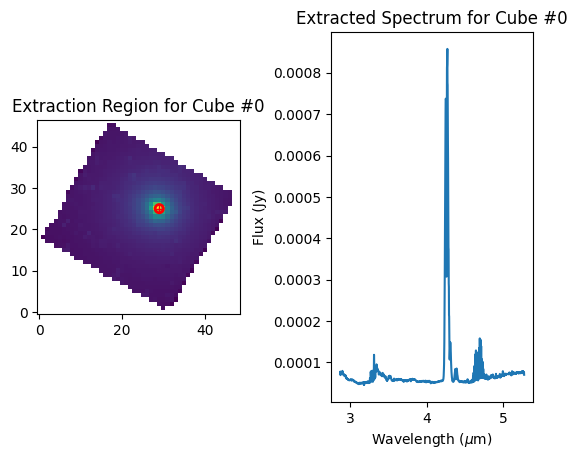

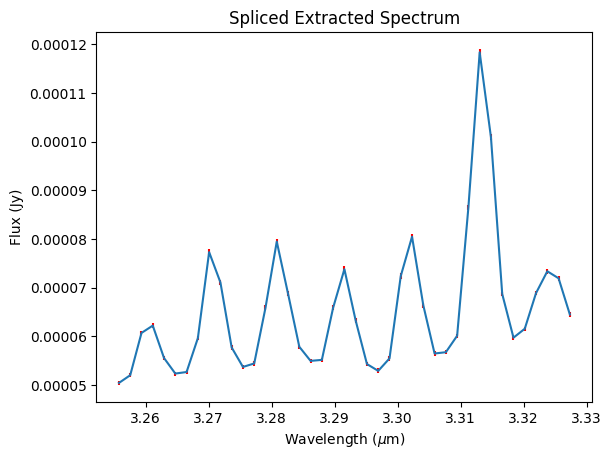

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1918    148 --:--:-- --:--:-- --:--:--  2068
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6198    0     0  100  6198      0  13919 --:--:-- --:--:-- --:--:-- 13928

Band sum = 5.815e-04


100  210k    0  204k  100  6198   292k   8855 --:--:-- --:--:-- --:--:--  301k


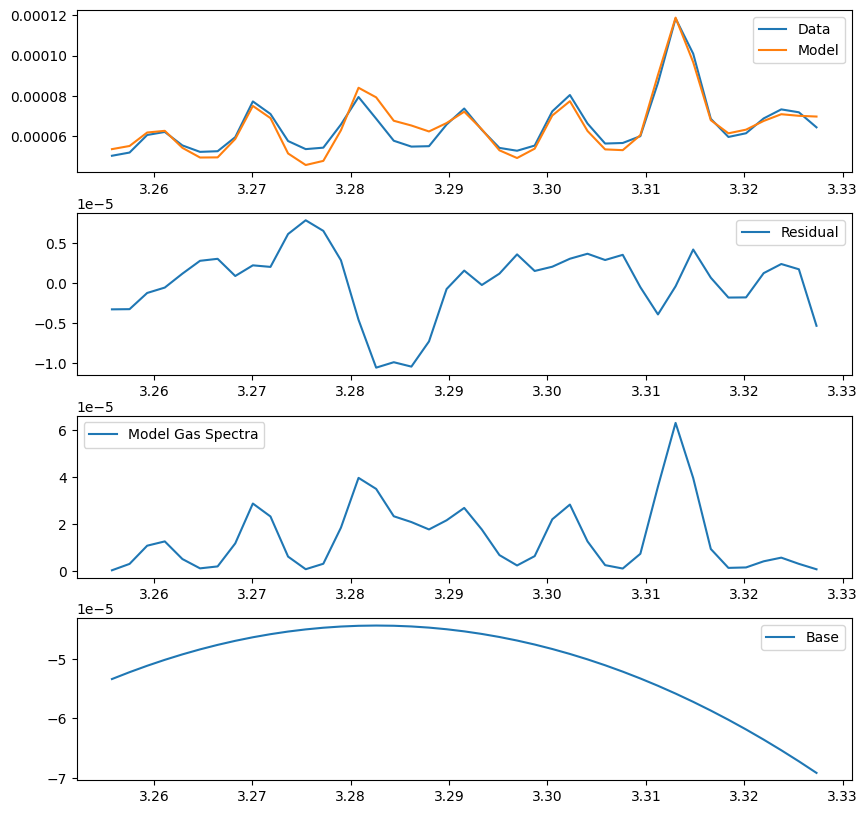

COMA-TEMPERATURE = 4.7360e+01 +- 4.4170e+00
COMA-CH4[CH4]
 = 2.9875e-01
 +- 2.0360e-02

Center coordinates are (29,25)


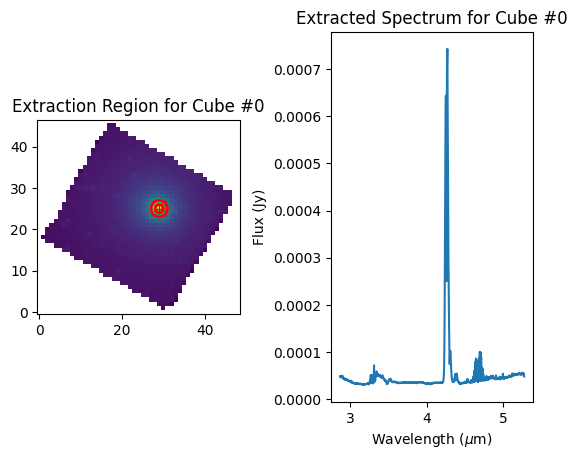

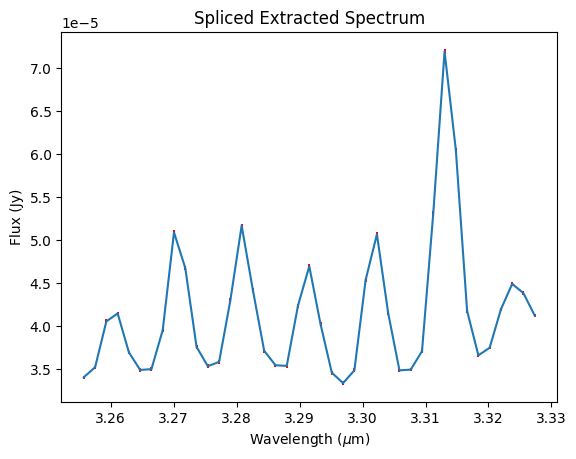

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1877    145 --:--:-- --:--:-- --:--:--  2023
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6242    0     0  100  6242      0  15413 --:--:-- --:--:-- --:--:-- 15450

Band sum = 2.935e-04


100  211k    0  204k  100  6242   311k   9496 --:--:-- --:--:-- --:--:--  321k


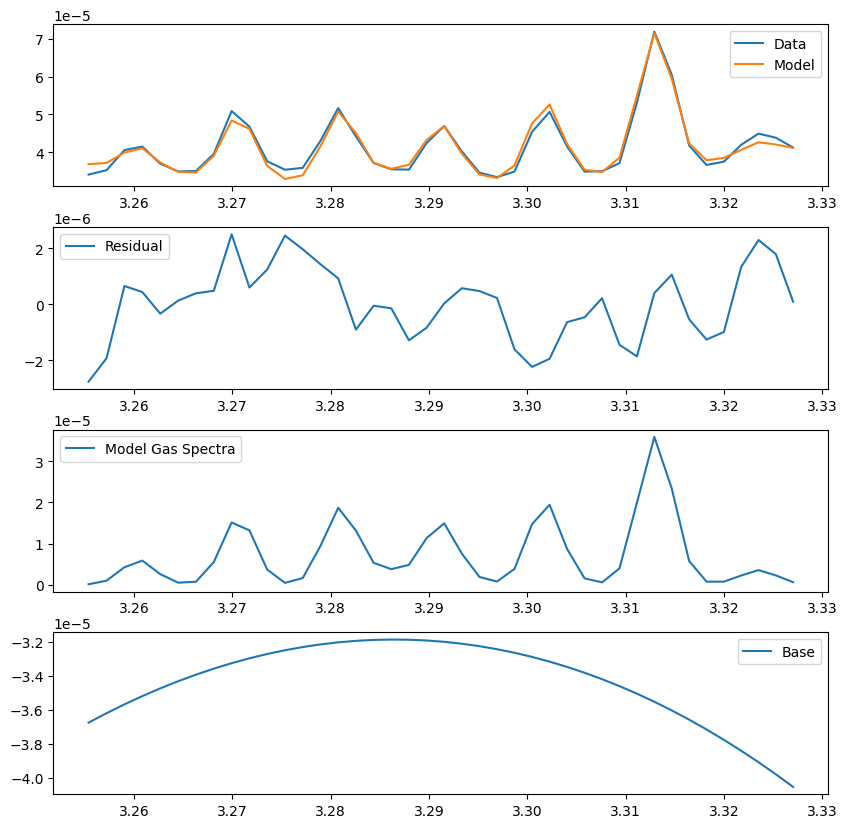

COMA-TEMPERATURE = 4.2390e+01 +- 9.8178e-01
COMA-CH4[CH4]
 = 1.0364e+00
 +- 3.3428e-02

Center coordinates are (29,25)


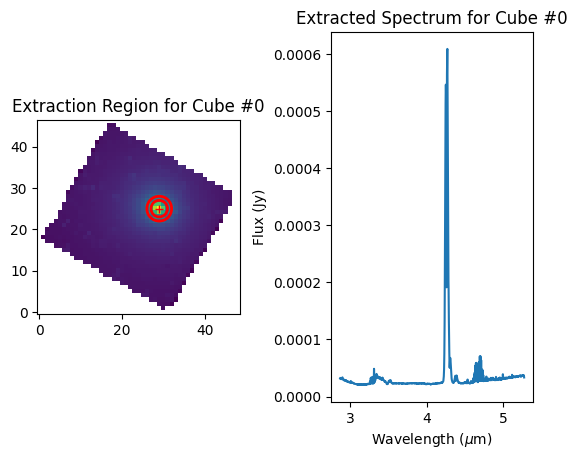

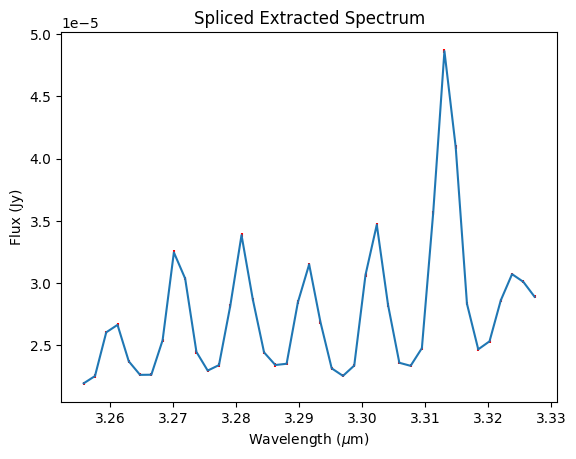

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1846    143 --:--:-- --:--:-- --:--:--  1990
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6251    0     0  100  6251      0  31910 --:--:-- --:--:-- --:--:-- 31892

Band sum = 1.929e-04


100  211k    0  204k  100  6251   184k   5636  0:00:01  0:00:01 --:--:--  190k


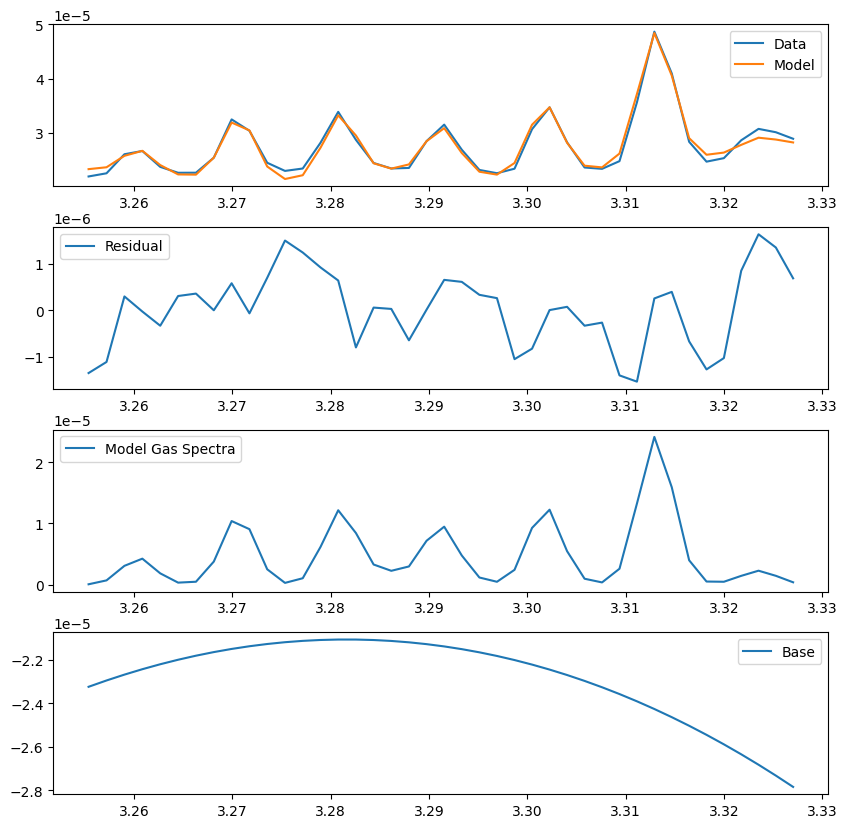

COMA-TEMPERATURE = 4.4026e+01 +- 9.6436e-01
COMA-CH4[CH4]
 = 1.1521e+00
 +- 3.5210e-02

Center coordinates are (29,25)


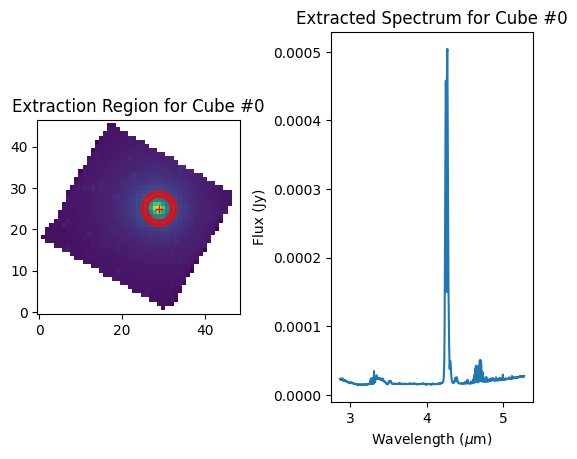

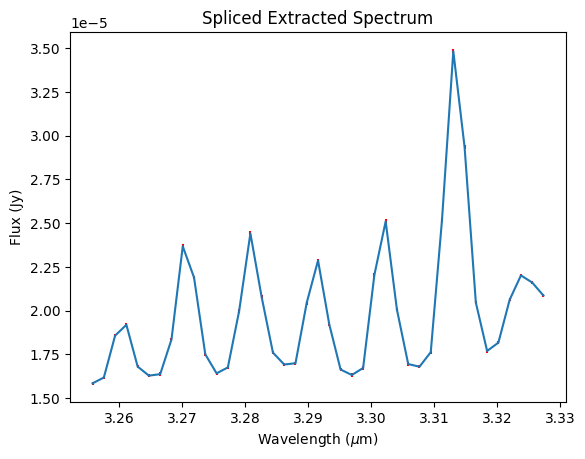

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1891    146 --:--:-- --:--:-- --:--:--  2039
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  125k    0  119k  100  6248  70835   3628  0:00:01  0:00:01 --:--:-- 74461

Band sum = 1.382e-04


100  211k    0  204k  100  6248   100k   3055  0:00:02  0:00:02 --:--:--  103k


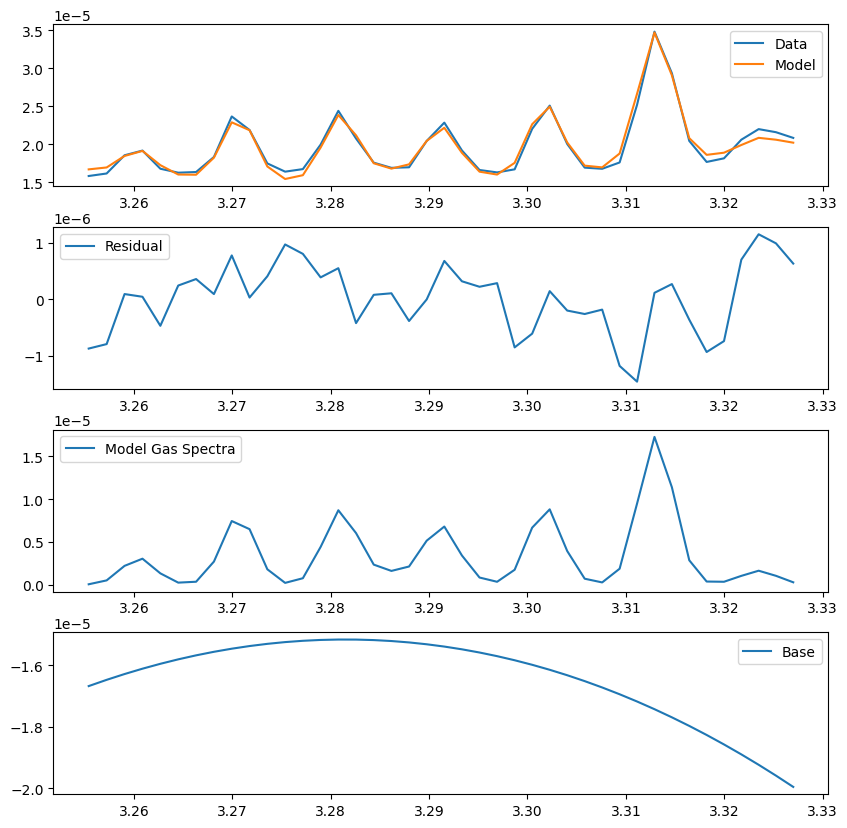

COMA-TEMPERATURE = 4.3942e+01 +- 1.6705e+00
COMA-CH4[CH4]
 = 1.1597e+00
 +- 3.6400e-02

Center coordinates are (29,25)


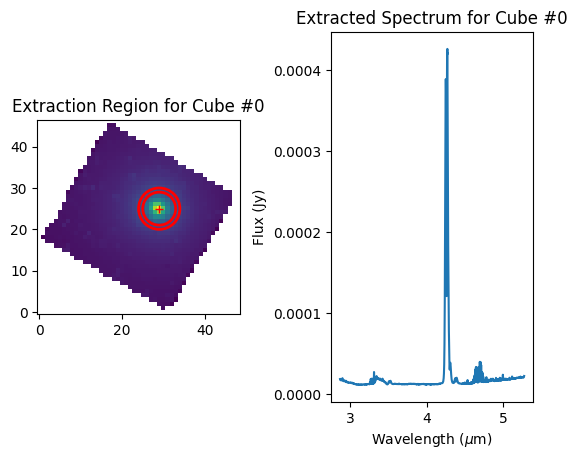

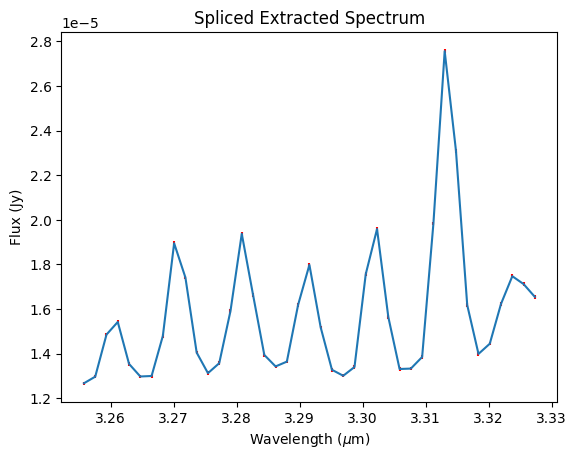

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1915    148 --:--:-- --:--:-- --:--:--  2065
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6227    0     0  100  6227      0  13824 --:--:-- --:--:-- --:--:-- 13837

Band sum = 1.078e-04


100  210k    0  204k  100  6227   290k   8828 --:--:-- --:--:-- --:--:--  299k


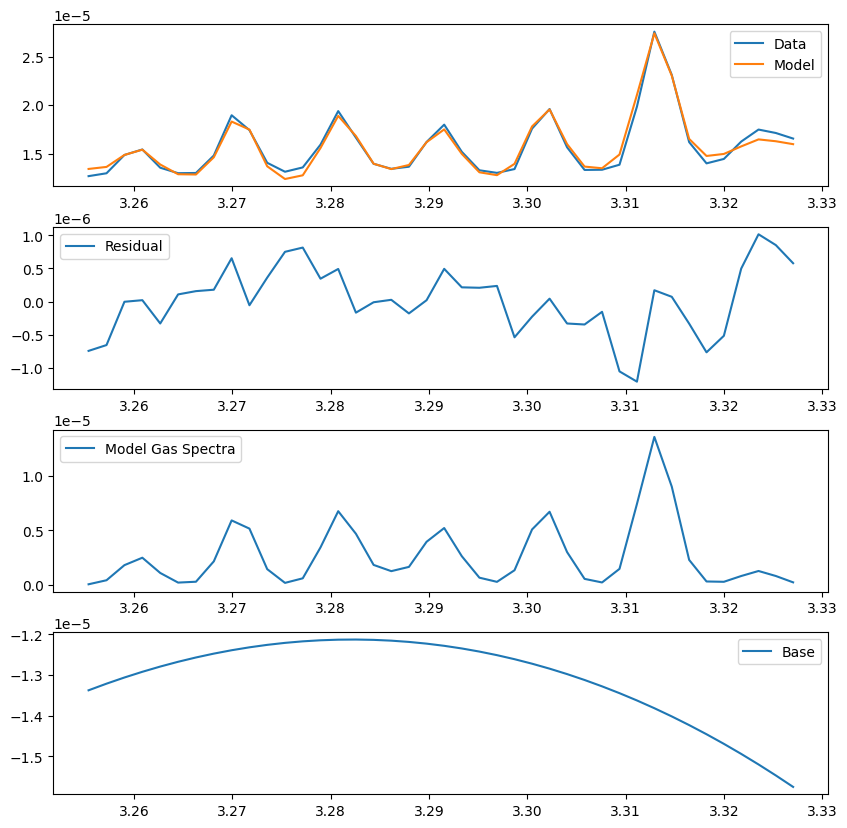

COMA-TEMPERATURE = 4.5053e+01 +- 1.8096e+00
COMA-CH4[CH4]
 = 1.1725e+00
 +- 3.8000e-02

Center coordinates are (29,25)


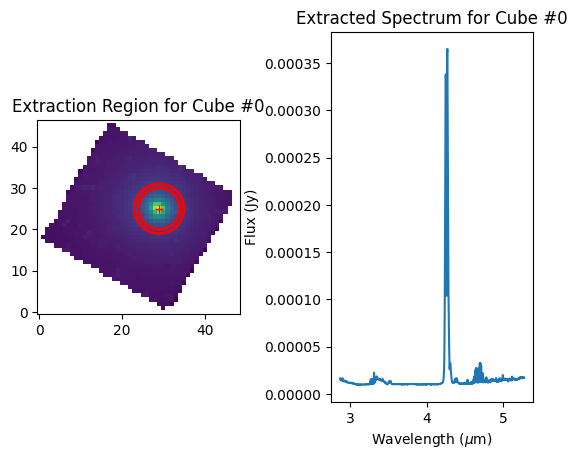

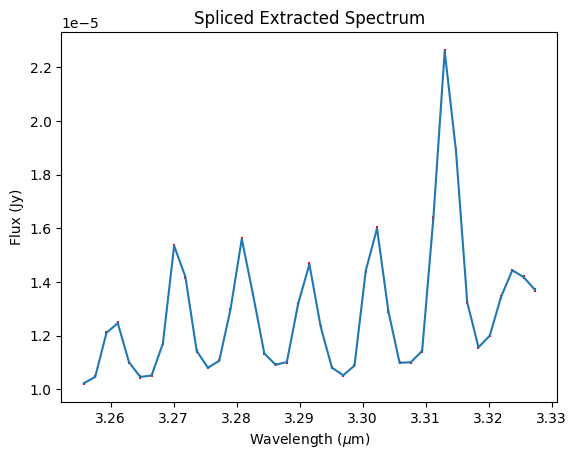

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2060    159 --:--:-- --:--:-- --:--:--  2221
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6235    0     0  100  6235      0  13976 --:--:-- --:--:-- --:--:-- 13979

Band sum = 8.762e-05


100  210k    0  204k  100  6235   292k   8905 --:--:-- --:--:-- --:--:--  301k


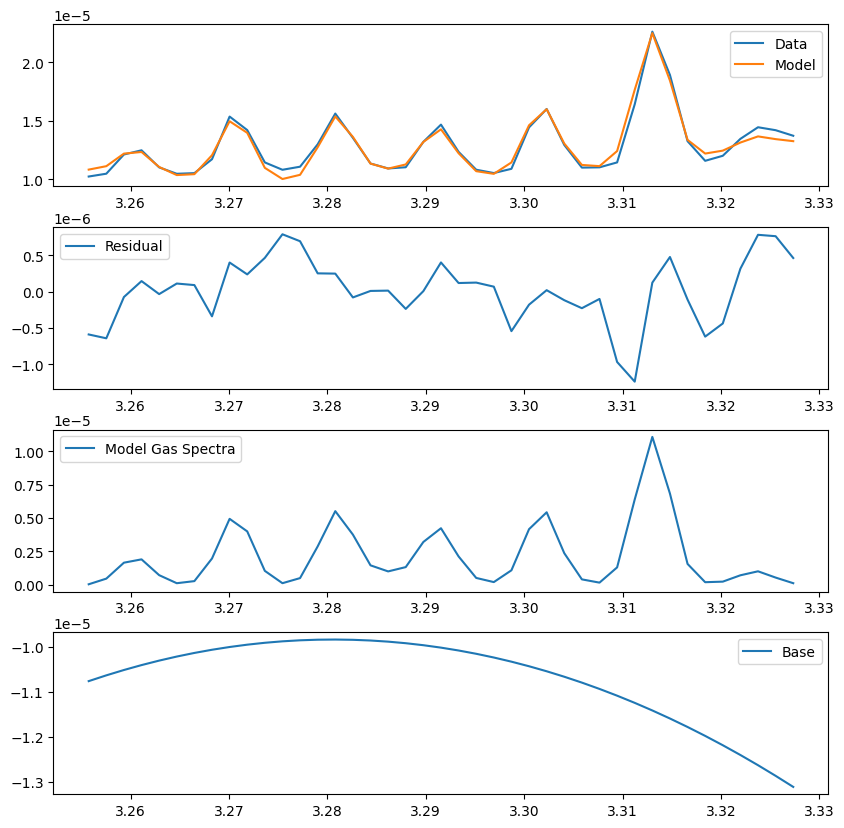

COMA-TEMPERATURE = 4.5412e+01 +- 1.9554e+00
COMA-CH4[CH4]
 = 1.1708e+00
 +- 4.1180e-02

Center coordinates are (29,25)


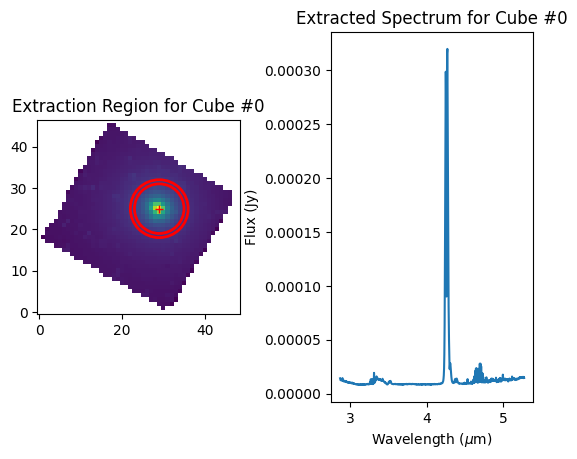

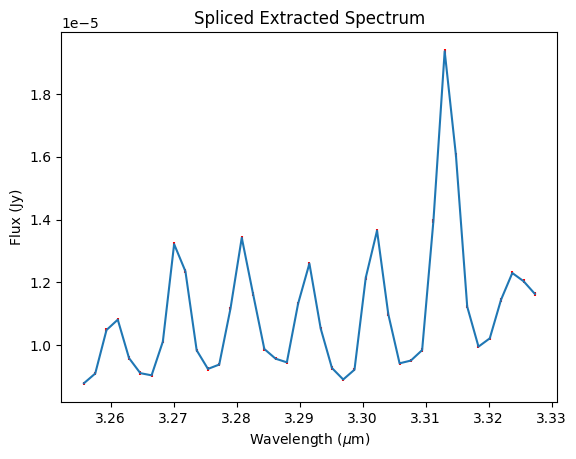

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1940    150 --:--:-- --:--:-- --:--:--  2092
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6224    0     0  100  6224      0  32043 --:--:-- --:--:-- --:--:-- 32082

Band sum = 7.421e-05


100  210k    0  204k  100  6224   266k   8115 --:--:-- --:--:-- --:--:--  274k


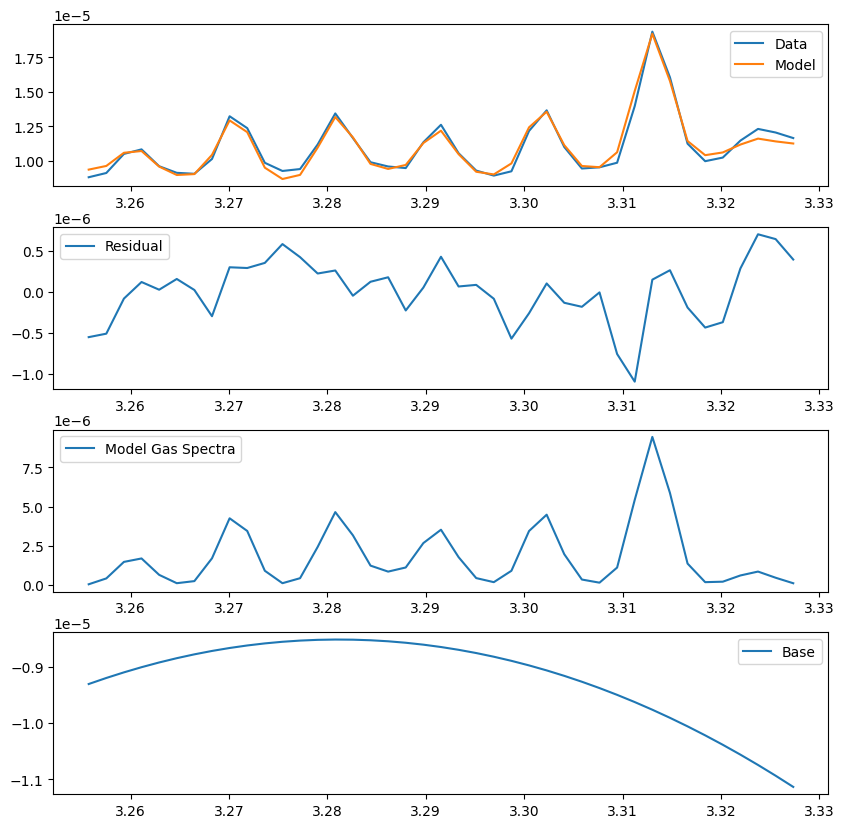

COMA-TEMPERATURE = 4.6246e+01 +- 2.0030e+00
COMA-CH4[CH4]
 = 1.1818e+00
 +- 4.0977e-02

Center coordinates are (29,25)


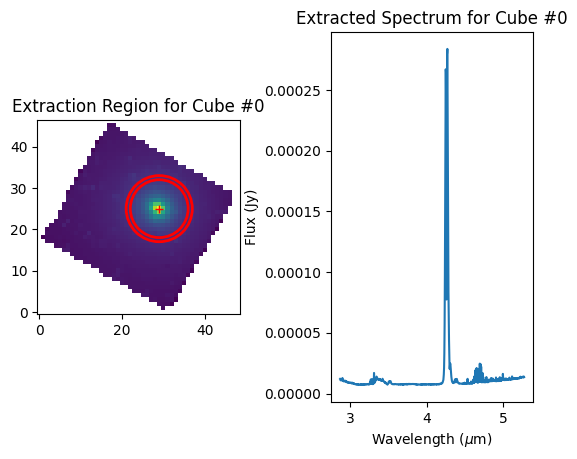

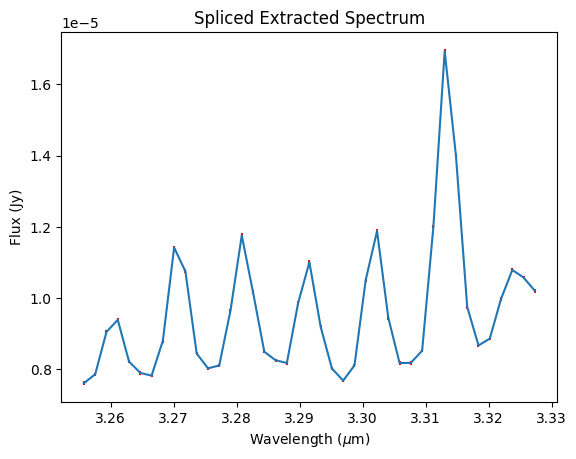

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2110    163 --:--:-- --:--:-- --:--:--  2278


Using STScI RP/dispersion lookup table
832.1376214178995 RP


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210k    0  204k  100  6218   291k   8842 --:--:-- --:--:-- --:--:--  300k


Band sum = 6.502e-05


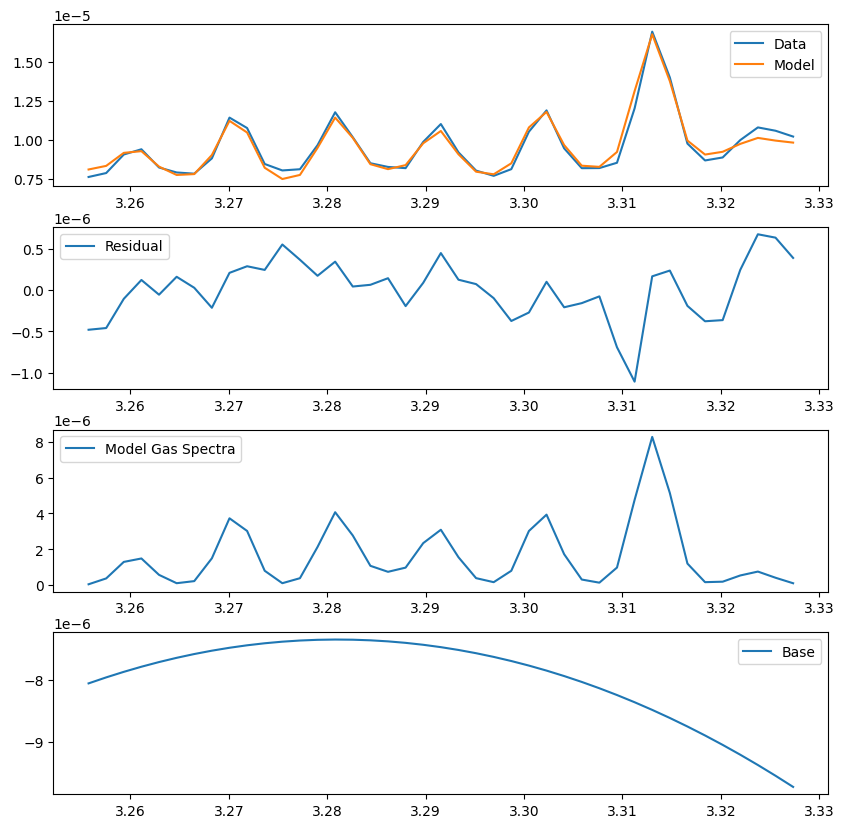

COMA-TEMPERATURE = 4.5864e+01 +- 2.1137e+00
COMA-CH4[CH4]
 = 1.2014e+00
 +- 4.4038e-02

Center coordinates are (29,25)


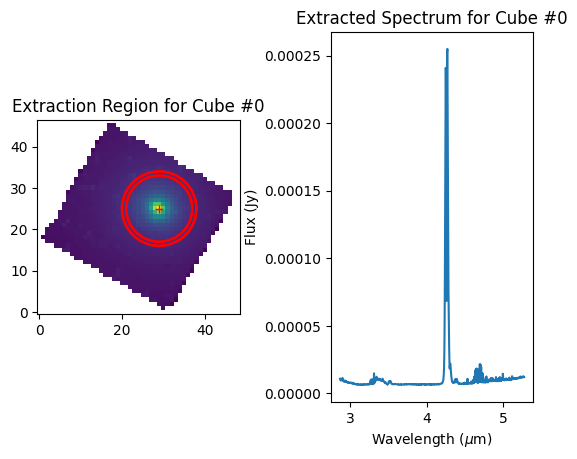

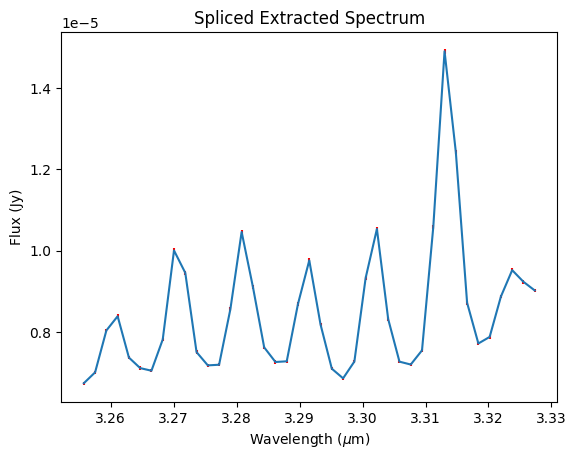

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1921    148 --:--:-- --:--:-- --:--:--  2072
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP
Band sum = 5.682e-05


100  210k    0  204k  100  6224   295k   8978 --:--:-- --:--:-- --:--:--  304k


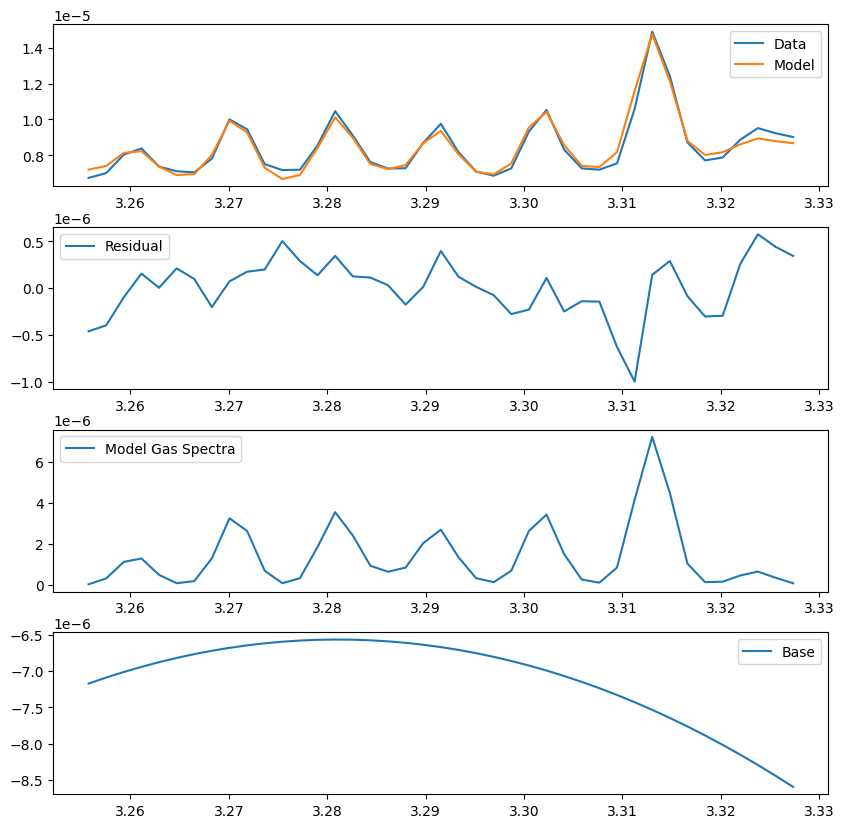

COMA-TEMPERATURE = 4.6137e+01 +- 2.1288e+00
COMA-CH4[CH4]
 = 1.1947e+00
 +- 4.4160e-02

Center coordinates are (29,25)


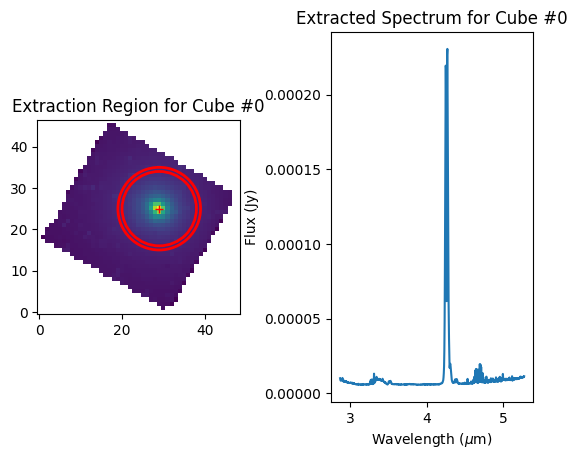

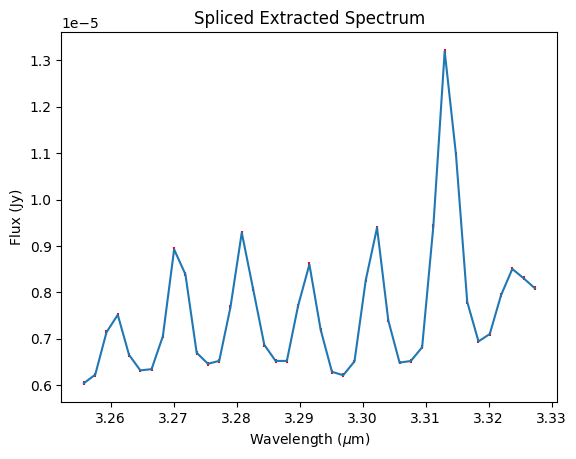

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2082    161 --:--:-- --:--:-- --:--:--  2244
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP
Band sum = 4.939e-05


100  210k    0  204k  100  6224   291k   8863 --:--:-- --:--:-- --:--:--  300k


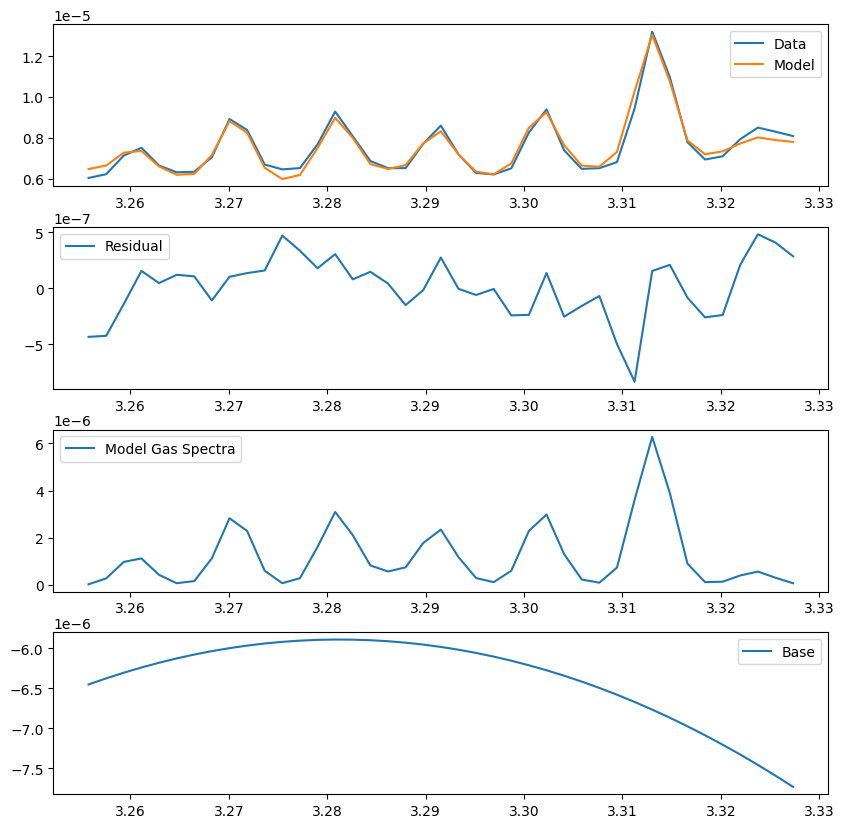

COMA-TEMPERATURE = 4.5916e+01 +- 2.1189e+00
COMA-CH4[CH4]
 = 1.1639e+00
 +- 4.2655e-02

Center coordinates are (29,25)


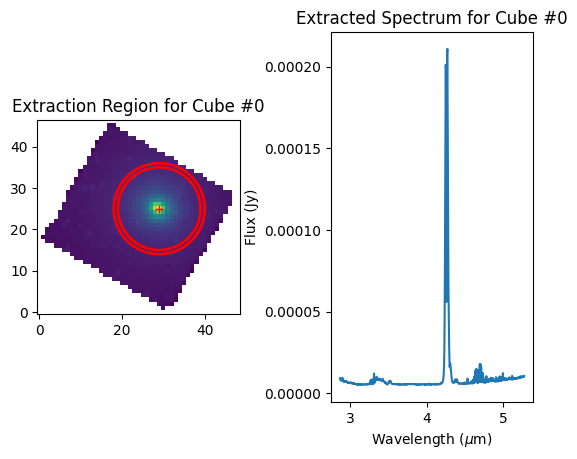

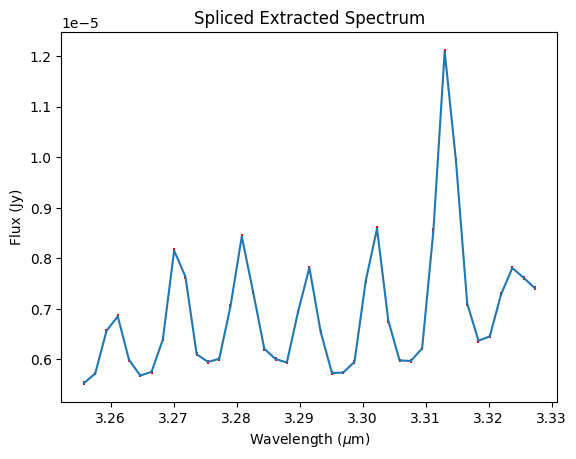

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2117    164 --:--:-- --:--:-- --:--:--  2284
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6220   287k   8731 --:--:-- --:--:-- --:--:--  296k


Band sum = 4.471e-05


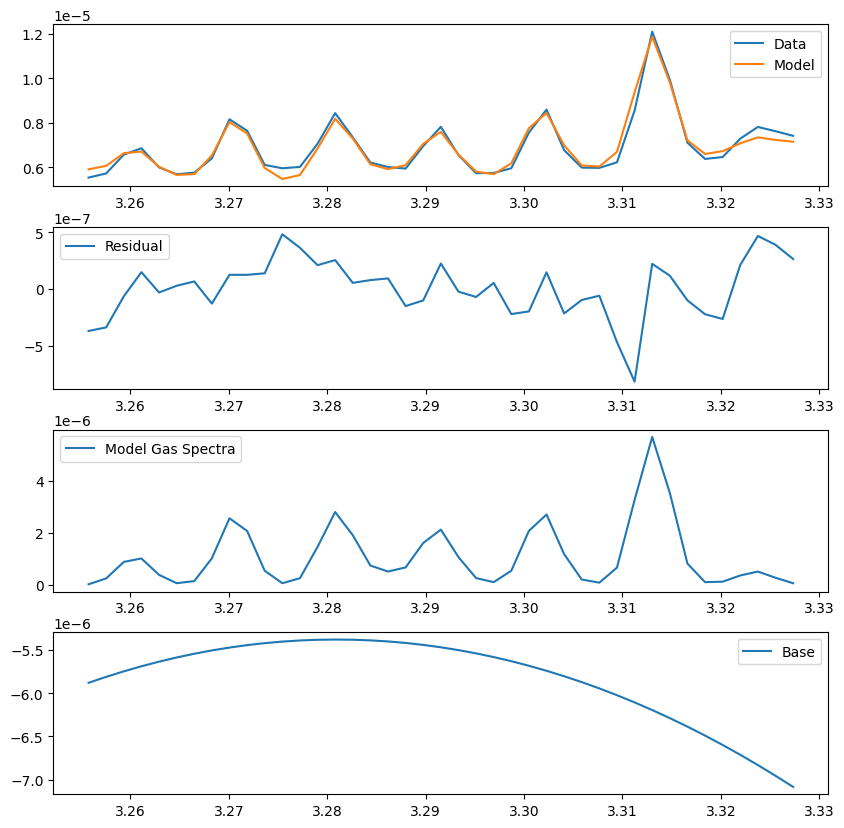

COMA-TEMPERATURE = 4.6287e+01 +- 2.1993e+00
COMA-CH4[CH4]
 = 1.1699e+00
 +- 4.4681e-02

Center coordinates are (29,25)


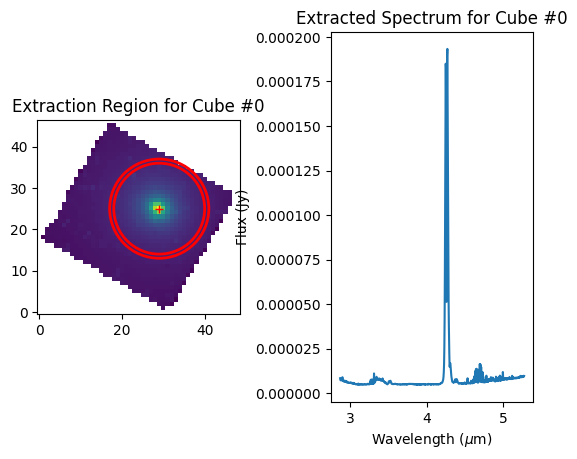

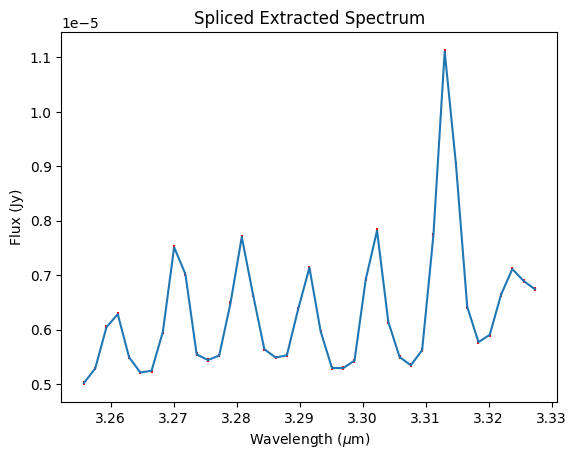

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2087    161 --:--:-- --:--:-- --:--:--  2249
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6225    0     0  100  6225      0   5209  0:00:01  0:00:01 --:--:--  5217

Band sum = 4.078e-05


100  210k    0  204k  100  6225   135k   4126  0:00:01  0:00:01 --:--:--  139k


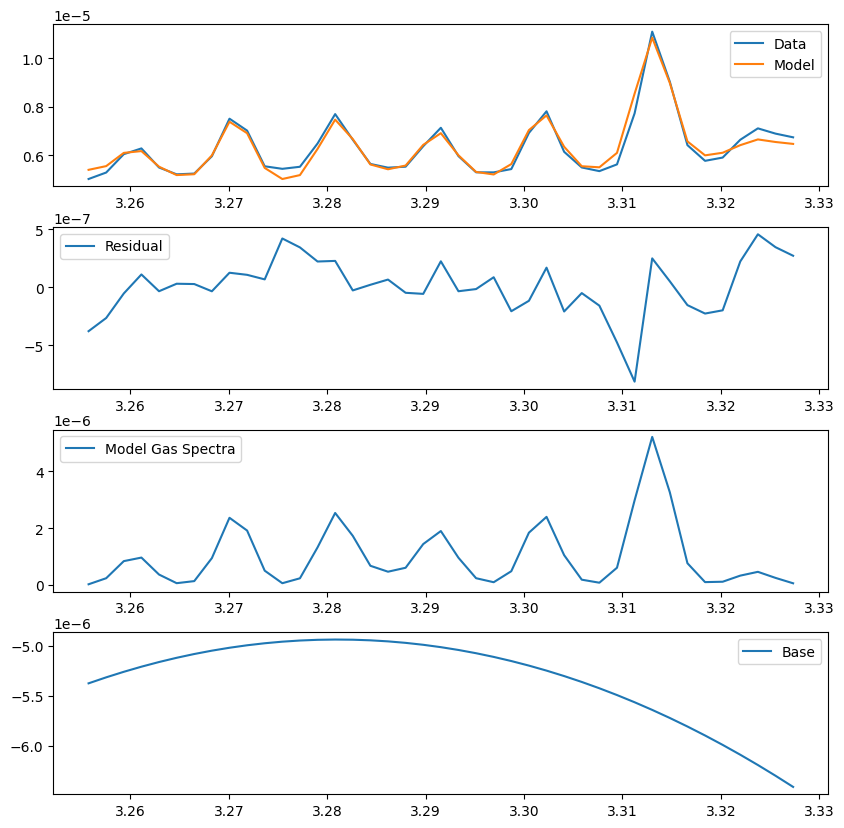

COMA-TEMPERATURE = 4.7168e+01 +- 2.3998e+00
COMA-CH4[CH4]
 = 1.1784e+00
 +- 4.6709e-02

Center coordinates are (29,25)


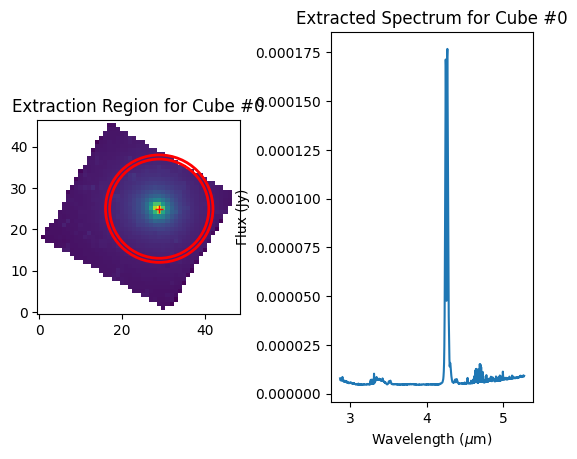

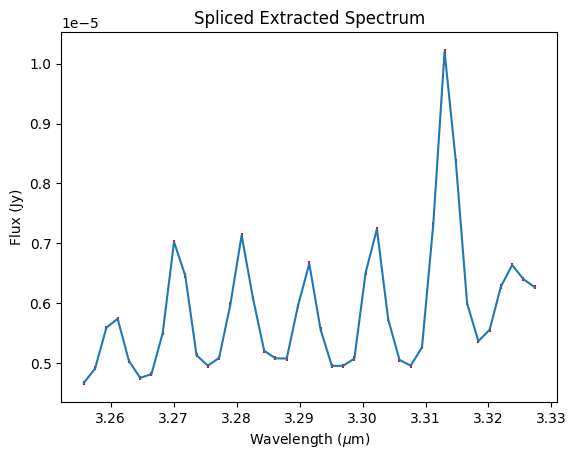

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2115    164 --:--:-- --:--:-- --:--:--  2281
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6220   244k   7434 --:--:-- --:--:-- --:--:--  252k


Band sum = 3.793e-05


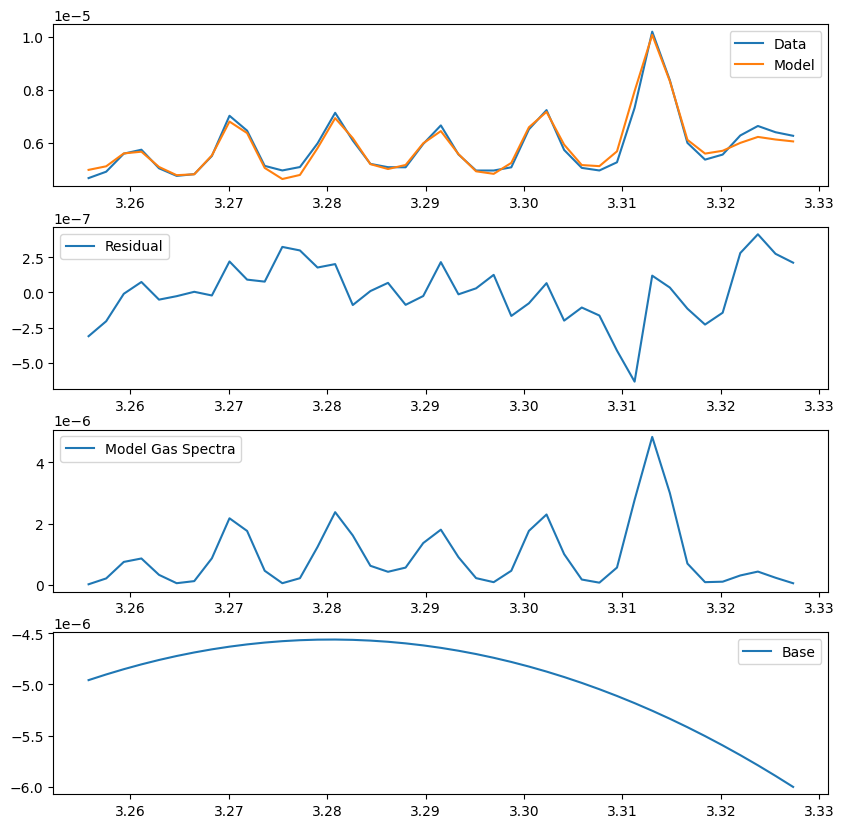

COMA-TEMPERATURE = 4.6017e+01 +- 2.0873e+00
COMA-CH4[CH4]
 = 1.1937e+00
 +- 4.3009e-02

Center coordinates are (29,25)


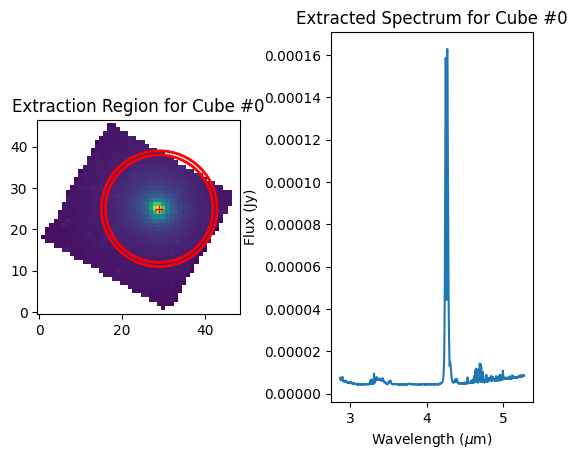

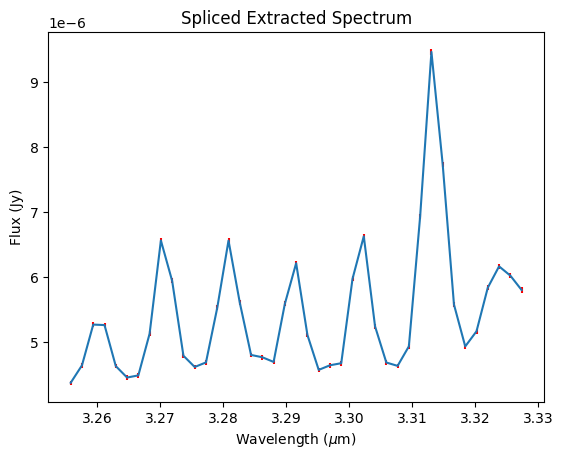

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1946    150 --:--:-- --:--:-- --:--:--  2099
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6221   100k   3060  0:00:02  0:00:02 --:--:--  103k


Band sum = 3.496e-05


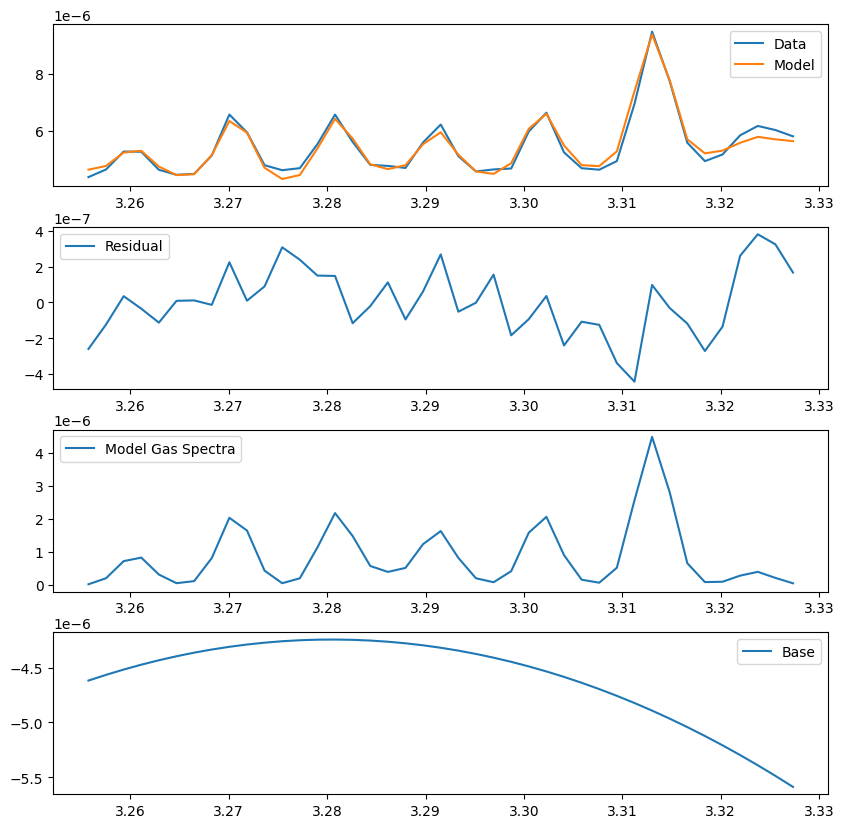

COMA-TEMPERATURE = 4.7042e+01 +- 2.1402e+00
COMA-CH4[CH4]
 = 1.1977e+00
 +- 4.2029e-02

Center coordinates are (29,25)


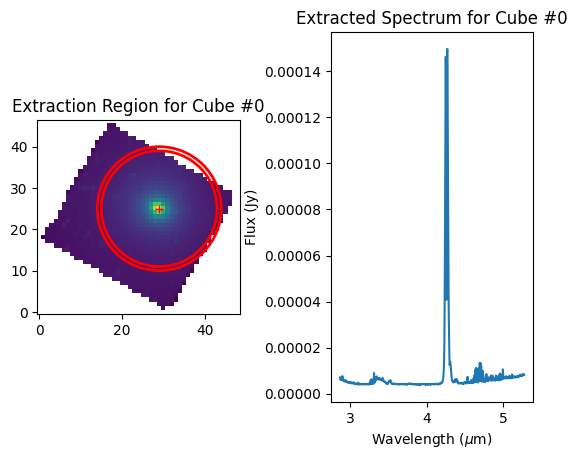

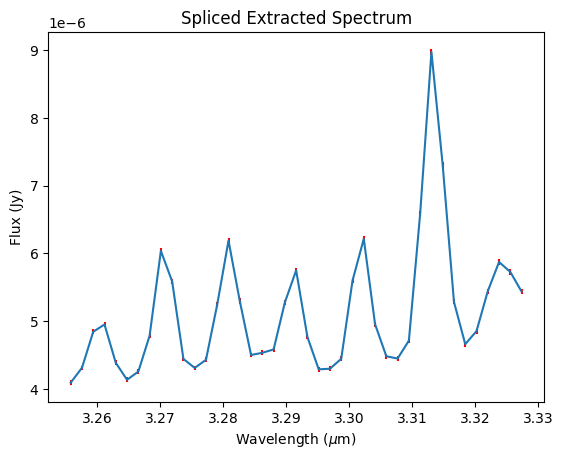

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2131    165 --:--:-- --:--:-- --:--:--  2301
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP
Band sum = 3.259e-05


100  210k    0  204k  100  6220   234k   7114 --:--:-- --:--:-- --:--:--  241k


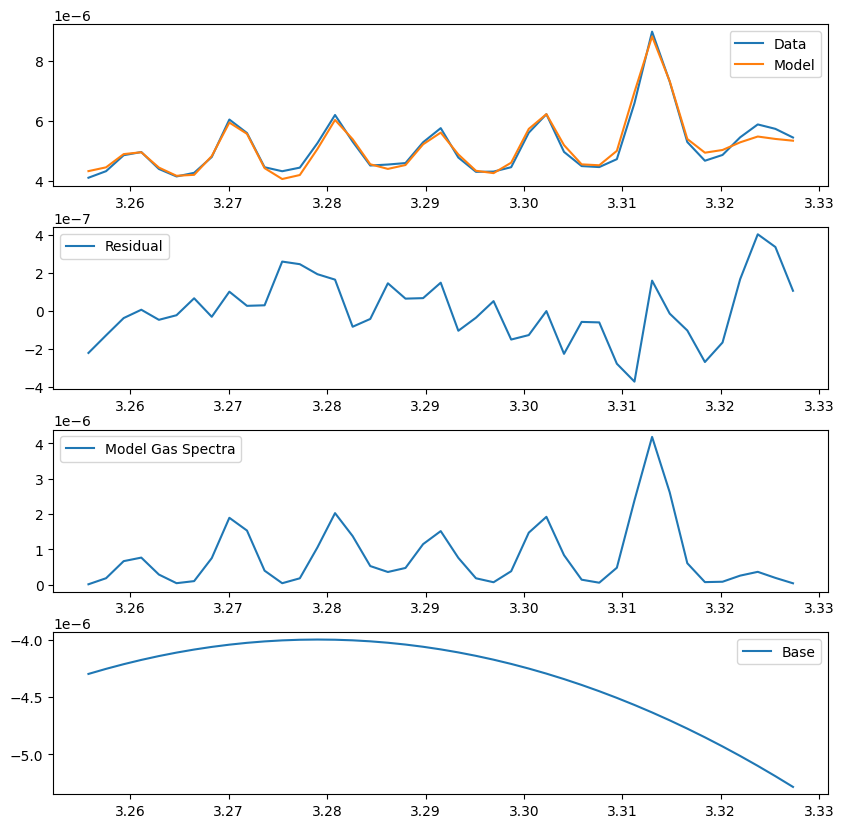

COMA-TEMPERATURE = 4.6626e+01 +- 2.0204e+00
COMA-CH4[CH4]
 = 1.2047e+00
 +- 4.0237e-02

Center coordinates are (29,25)


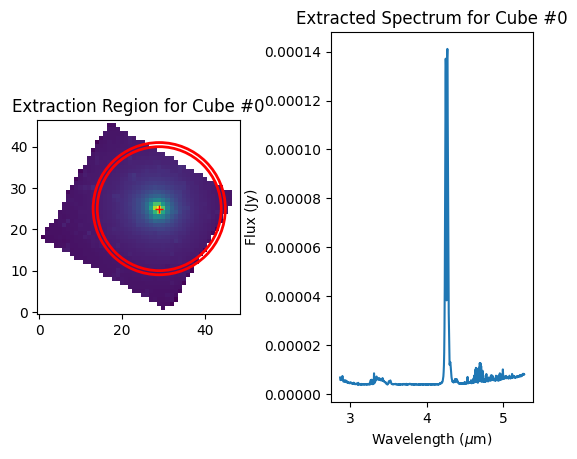

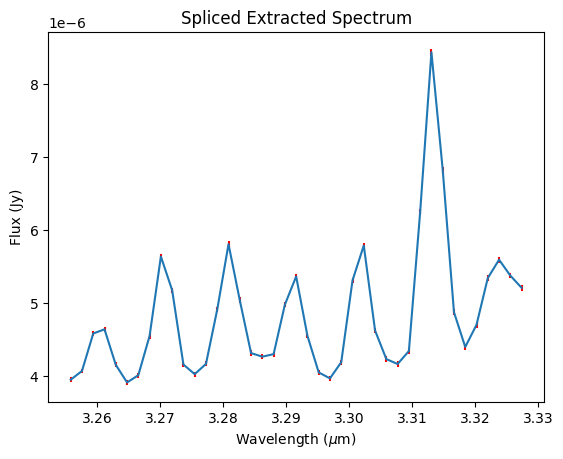

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2145    166 --:--:-- --:--:-- --:--:--  2313
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6219   292k   8887 --:--:-- --:--:-- --:--:--  301k


Band sum = 3.034e-05


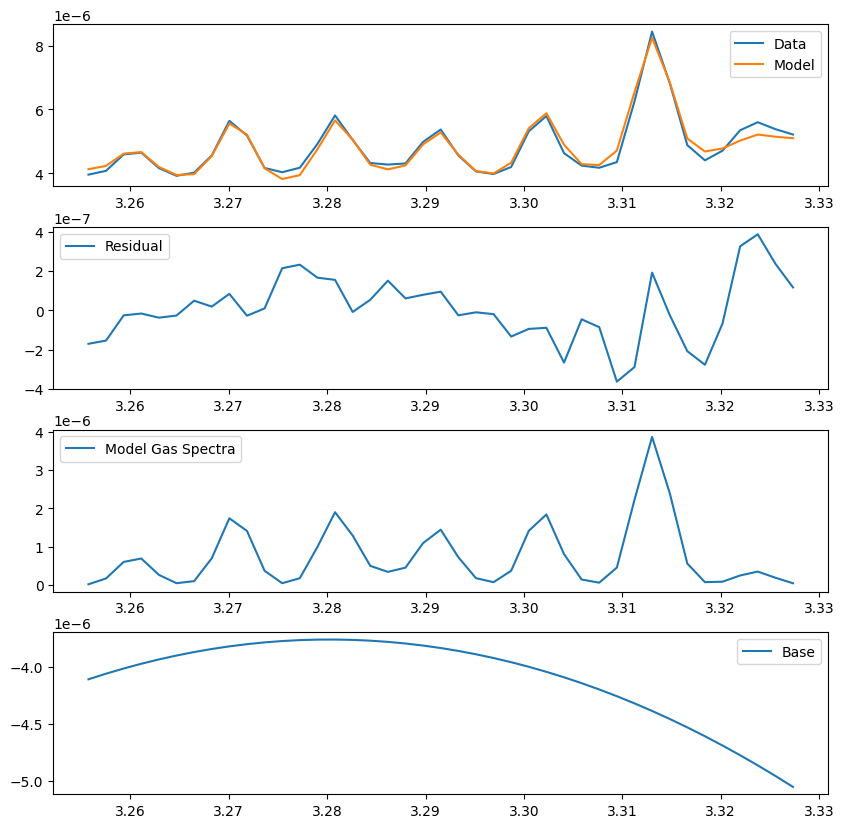

COMA-TEMPERATURE = 4.6059e+01 +- 2.0277e+00
COMA-CH4[CH4]
 = 1.1993e+00
 +- 4.2306e-02

Center coordinates are (29,25)


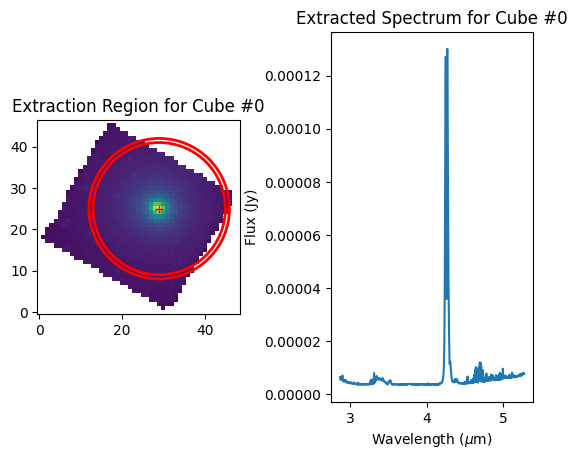

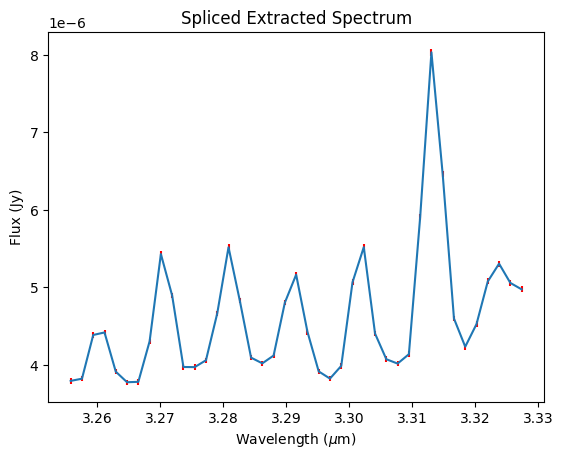

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2051    159 --:--:-- --:--:-- --:--:--  2210
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6218   283k   8608 --:--:-- --:--:-- --:--:--  291k


Band sum = 2.842e-05


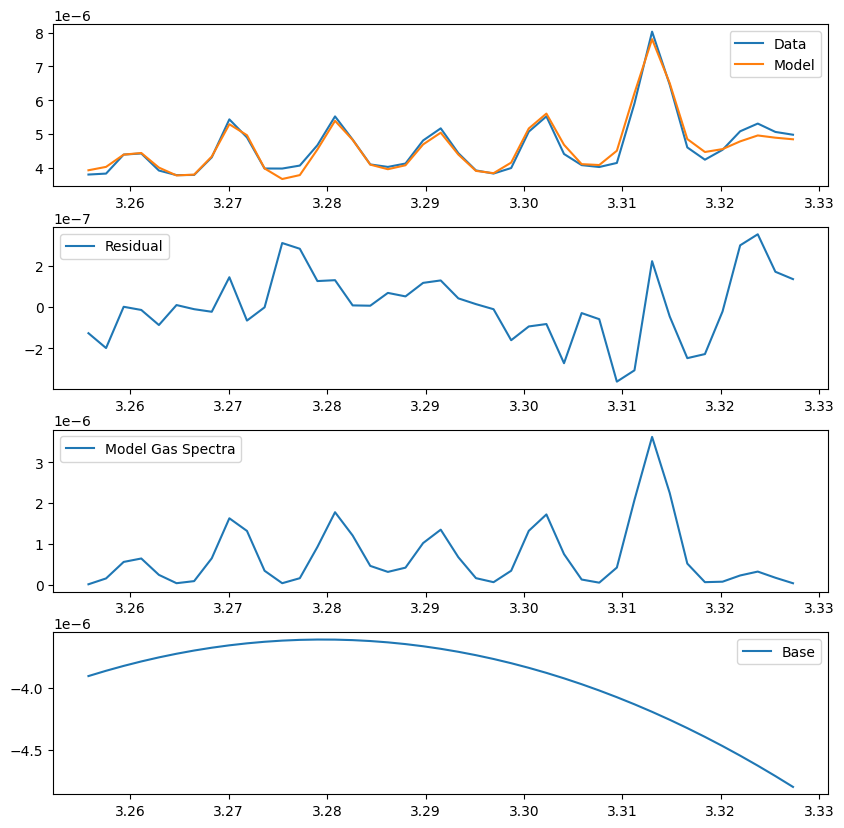

COMA-TEMPERATURE = 4.6418e+01 +- 2.2115e+00
COMA-CH4[CH4]
 = 1.2013e+00
 +- 4.5865e-02

Center coordinates are (29,25)


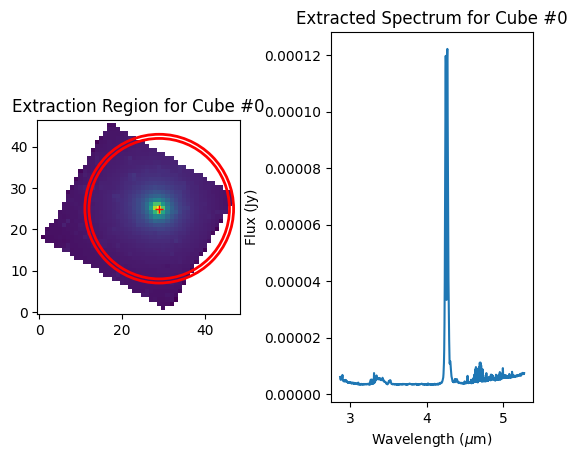

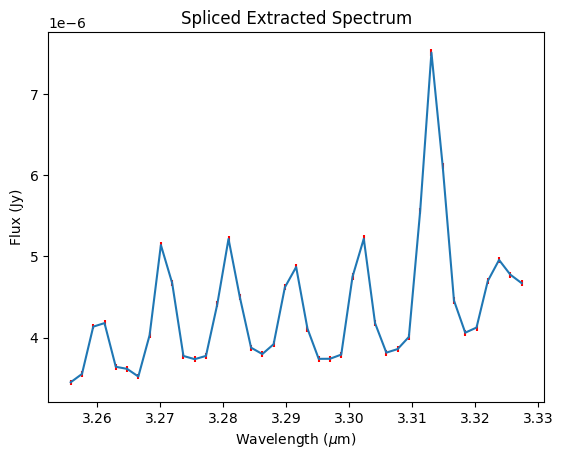

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1957    151 --:--:-- --:--:-- --:--:--  2109
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6219    0     0  100  6219      0   7476 --:--:-- --:--:-- --:--:--  7483

Band sum = 2.636e-05


100  210k    0  204k  100  6219   187k   5710  0:00:01  0:00:01 --:--:--  193k


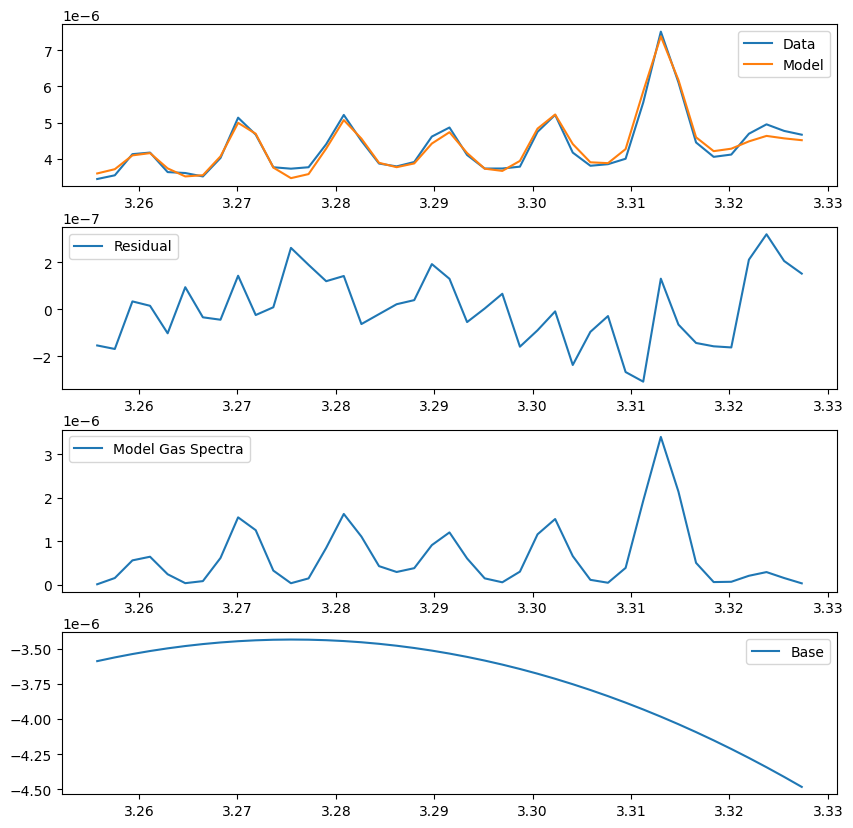

COMA-TEMPERATURE = 4.7754e+01 +- 2.3443e+00
COMA-CH4[CH4]
 = 1.1943e+00
 +- 4.3744e-02

Center coordinates are (29,25)


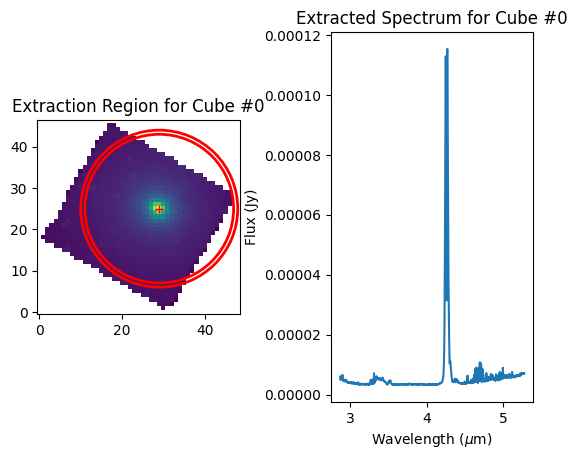

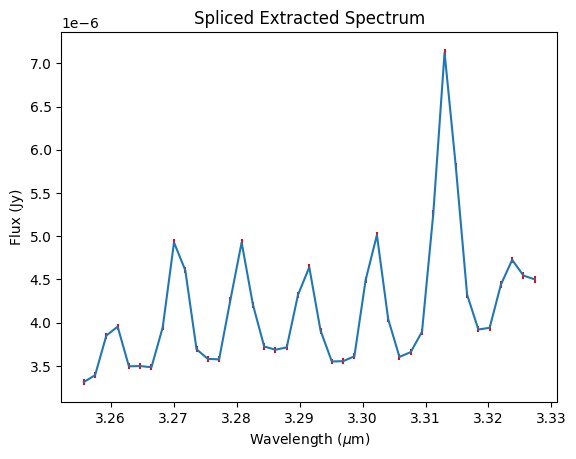

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1992    154 --:--:-- --:--:-- --:--:--  2147
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6223    0     0  100  6223      0   5222  0:00:01  0:00:01 --:--:--  5229

Band sum = 2.478e-05


100  210k    0  204k  100  6223   136k   4158  0:00:01  0:00:01 --:--:--  141k


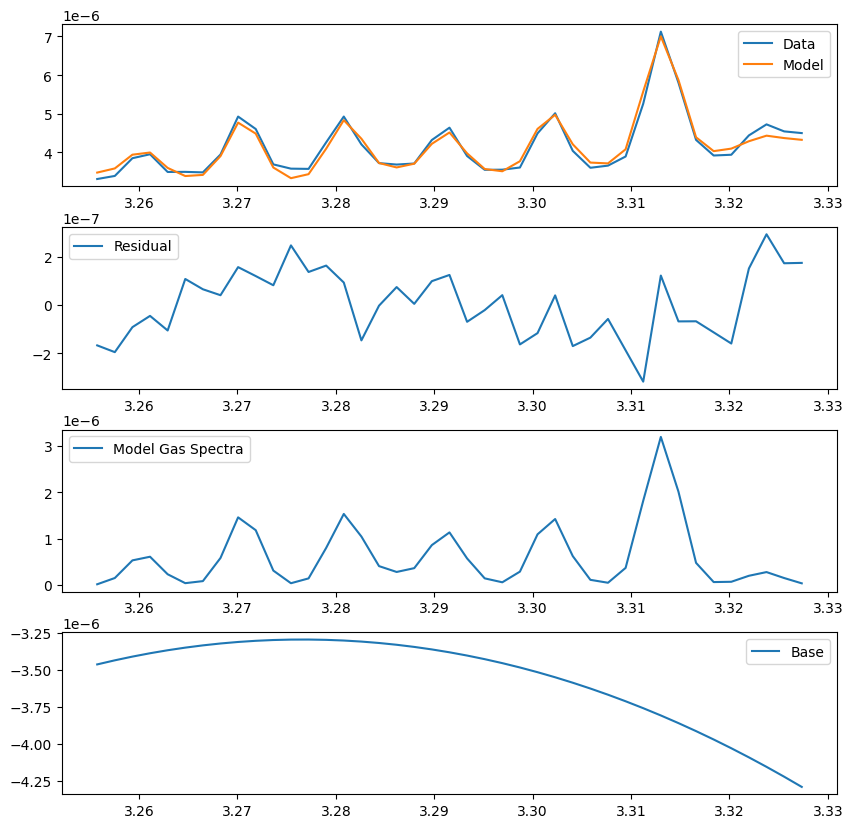

COMA-TEMPERATURE = 4.7868e+01 +- 2.3358e+00
COMA-CH4[CH4]
 = 1.1912e+00
 +- 4.3704e-02

Center coordinates are (29,25)


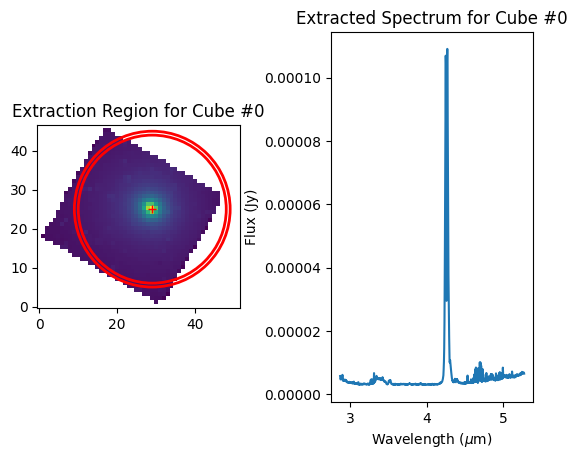

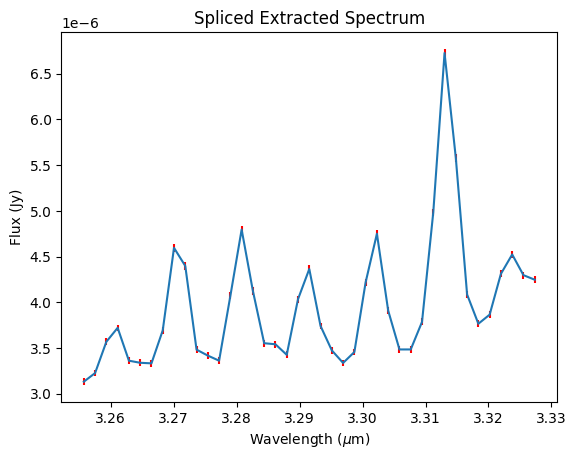

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2161    167 --:--:-- --:--:-- --:--:--  2328
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6232   278k   8462 --:--:-- --:--:-- --:--:--  286k


Band sum = 2.313e-05


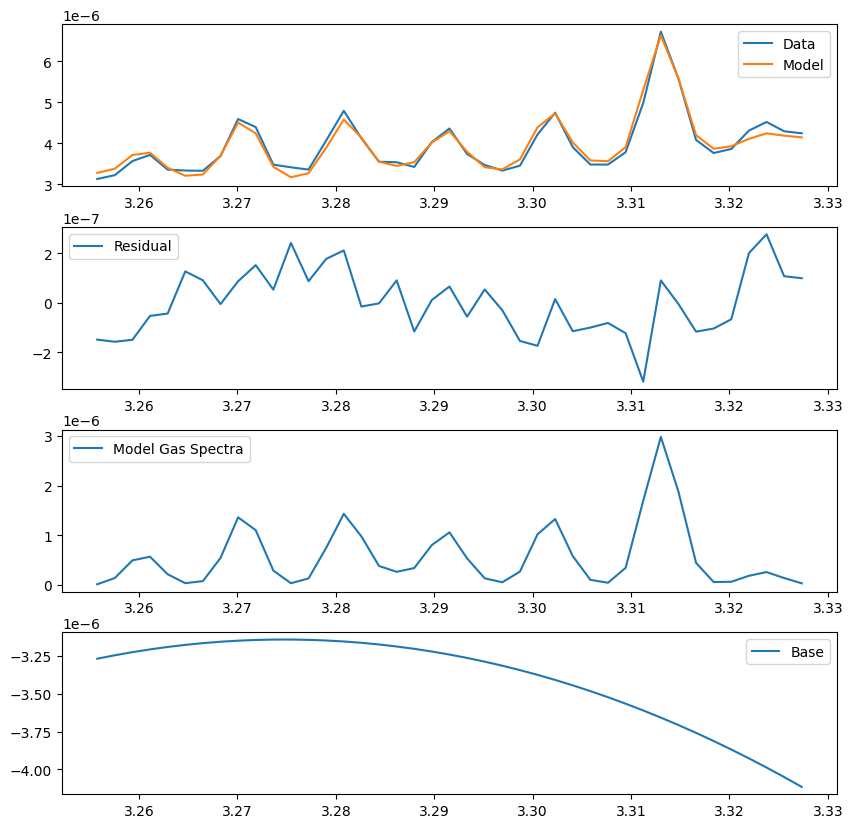

COMA-TEMPERATURE = 4.7875e+01 +- 2.3021e+00
COMA-CH4[CH4]
 = 1.1760e+00
 +- 4.3098e-02

Center coordinates are (29,25)


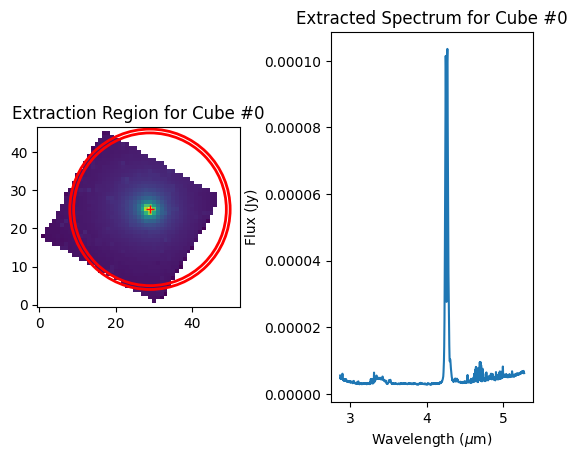

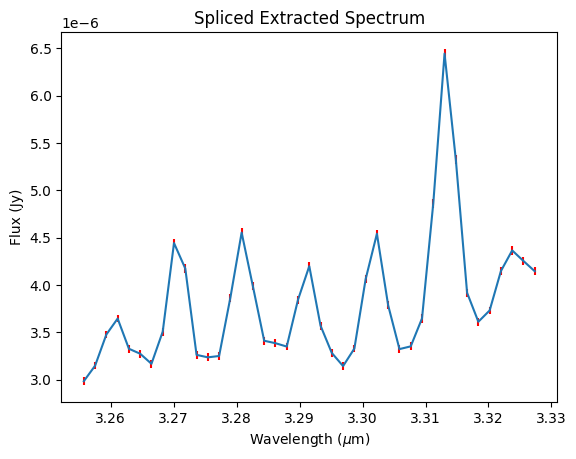

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   2016    156 --:--:-- --:--:-- --:--:--  2173
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6234  92498   2749  0:00:02  0:00:02 --:--:-- 95268


Band sum = 2.228e-05


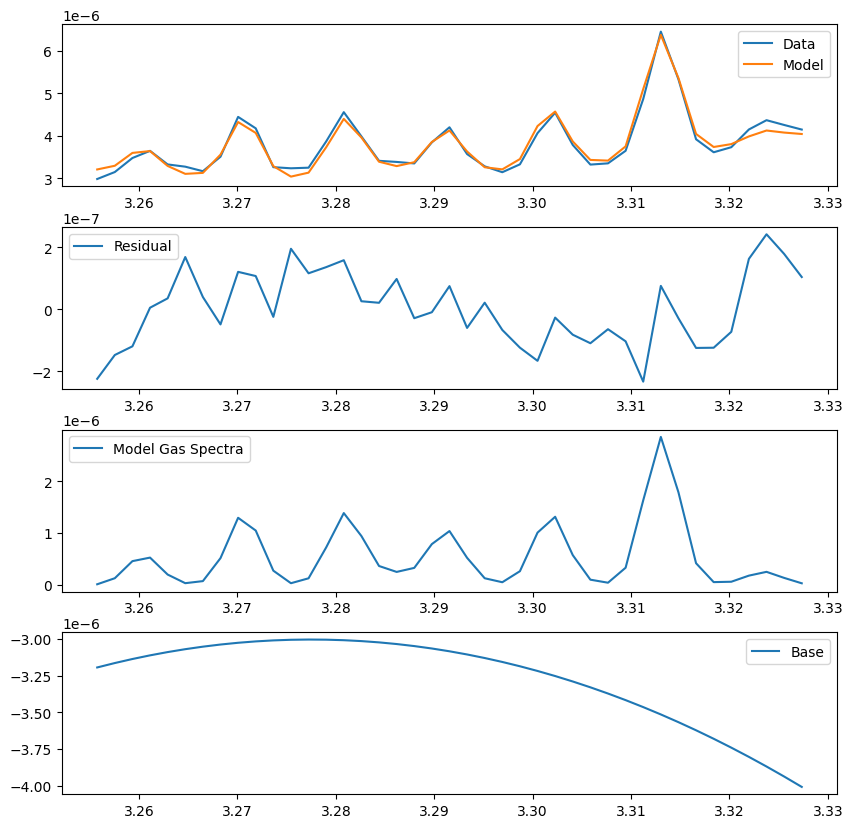

COMA-TEMPERATURE = 4.7467e+01 +- 2.9939e+00
COMA-CH4[CH4]
 = 1.1925e+00
 +- 4.2689e-02

Center coordinates are (29,25)


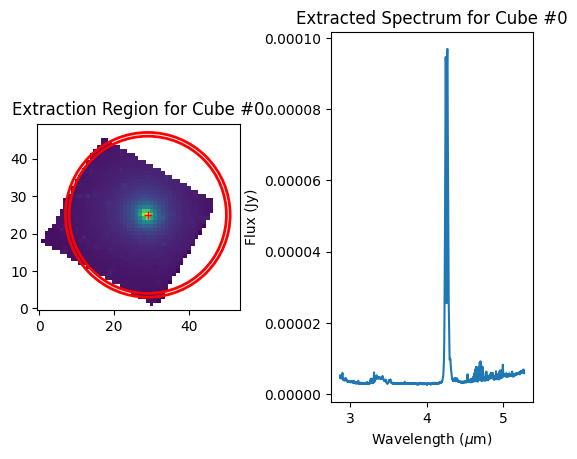

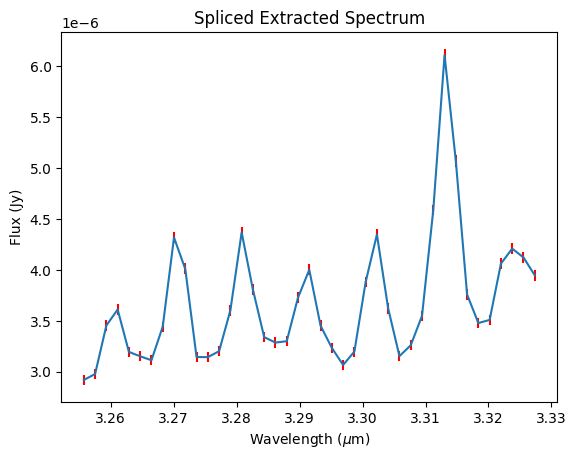

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1857    143 --:--:-- --:--:-- --:--:--  2001
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6240    0     0  100  6240      0   5133  0:00:01  0:00:01 --:--:--  5135

Band sum = 2.049e-05


100  210k    0  204k  100  6240   132k   4031  0:00:01  0:00:01 --:--:--  136k


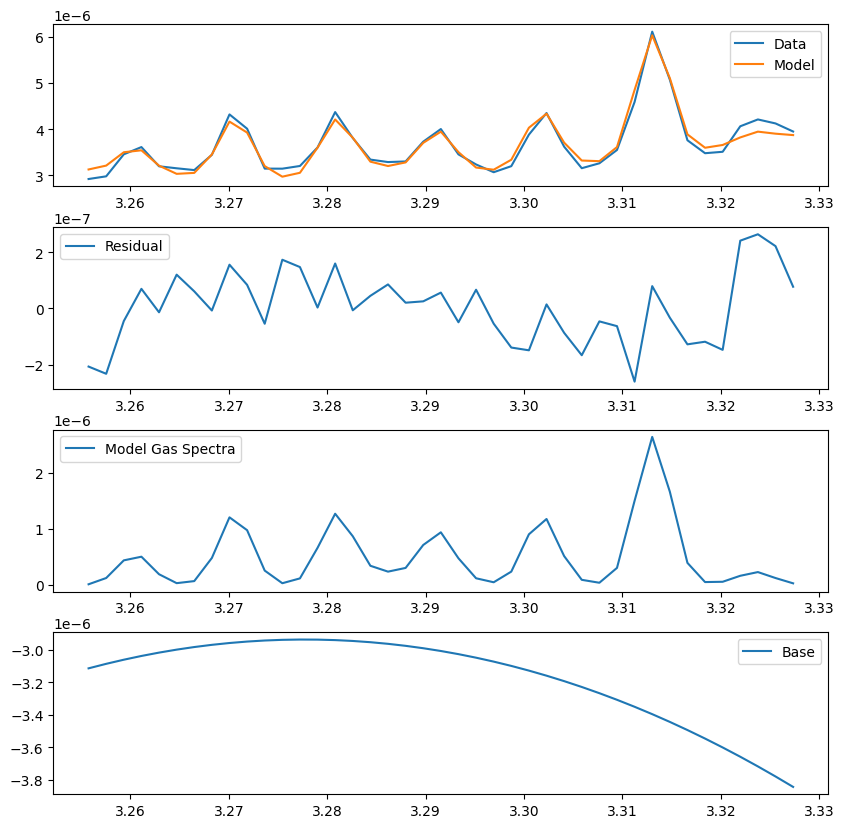

COMA-TEMPERATURE = 4.8452e+01 +- 4.3243e+00
COMA-CH4[CH4]
 = 1.1562e+00
 +- 4.8753e-02

Center coordinates are (29,25)


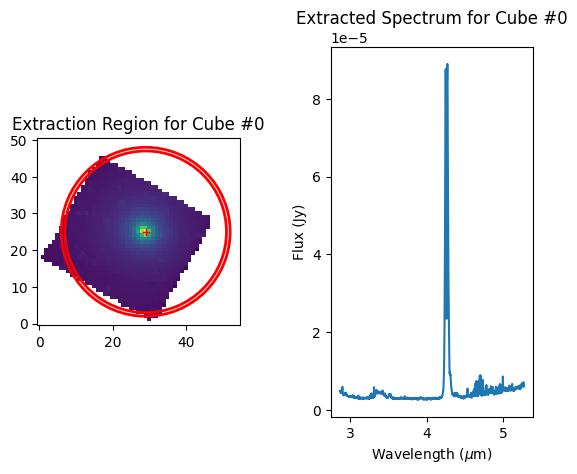

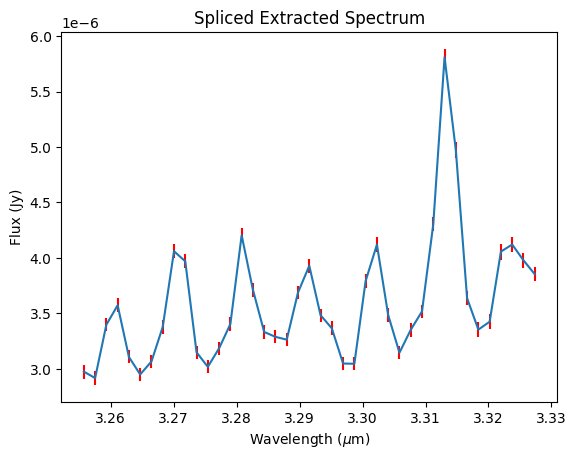

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1871    145 --:--:-- --:--:-- --:--:--  2019
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  210k    0  204k  100  6218   116k   3529  0:00:01  0:00:01 --:--:--  119k


Band sum = 1.814e-05


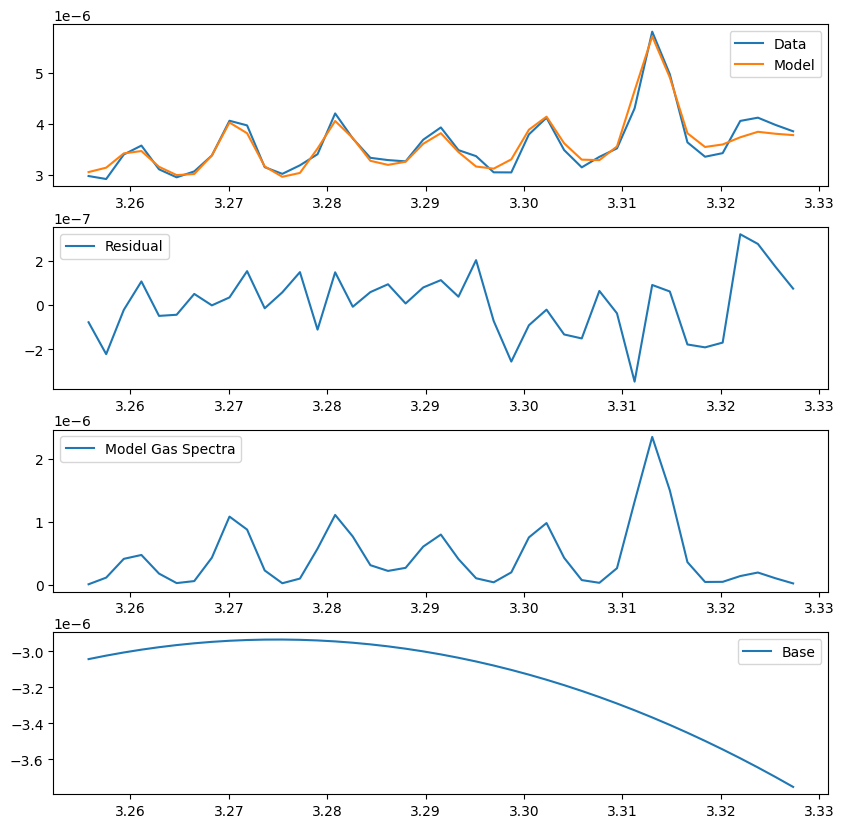

COMA-TEMPERATURE = 5.0421e+01 +- 7.6736e+00
COMA-CH4[CH4]
 = 1.0777e+00
 +- 5.7816e-02



In [6]:
#Now run new retrievals if requested
local=False #set to False for a locally installed version of PSG, or True to use the psg.gsfc.nasa.gov server
withCont=False #set to False to prevent a thermal emission continuum model being used (i.e., simply fit a baseline)
withPlots = True #Include output plots
if run_ret:
    #Extract and construct a radial profile
    #Arrays to hold the retrieved variables, values, and sigmas
    retrieval_variables = []
    retrieval_values    = []
    retrieval_sigmas    = []

    for r_in, r_out in zip(annuli.r_ins, annuli.r_outs):

        #Name for our extracted spectrum
        specFile = 'JWST-Extract-{:.2f}-arcsecInnerRadius-{:.2f}-arcsecOuterRadius-{:.2f}um-to-{:.2f}um.txt'.format(r_in.value,r_out.value,waveLo.value,waveUp.value)
        
        #Initialize the extraction routine
        annulus = extraction.Azimuthal()
        
        #Extract the azimuthally averaged spectrum
        annulusExtract = annulus.extractSpec(cubeFiles=files, specFile=specFile, waveLo=waveLo, waveUp=waveUp, 
                                             innerRadius=r_in, outerRadius=r_out, withPlots=withPlots)
        #Initialize the modeling routine
        annulusModel = modeling.runPSG()
        #Name of file where our model results are saved
        resFile = specFile[:-3]+'retrieval-results.txt'
        #Send the data to the PSG for the requested coma model and/or retrieval
        annulusModel.getModels(specFile=specFile, resFile=resFile, name=cometName, objectType='Comet', composition=coma_dict, 
                               retrieval_options=retrieval_options, retrieval=retrieval_dict, mode='azimuthal', withCont=withCont,
                               withPlots=withPlots, local=local)
        #Read the results and add them to our arrays
        results = modeling.readPSG(resFile)
        retrieval_variables.append(results.retrieval_variables)
        retrieval_values.append(results.retrieval_values)
        retrieval_sigmas.append(results.retrieval_sigmas)

Average terminal value for COMA-TEMPERATURE = 47.45345758698158 +- 1.0721318343231958
Average terminal value for COMA-CH4[CH4] = 1.1907980200937893 +- 0.019579125969108938


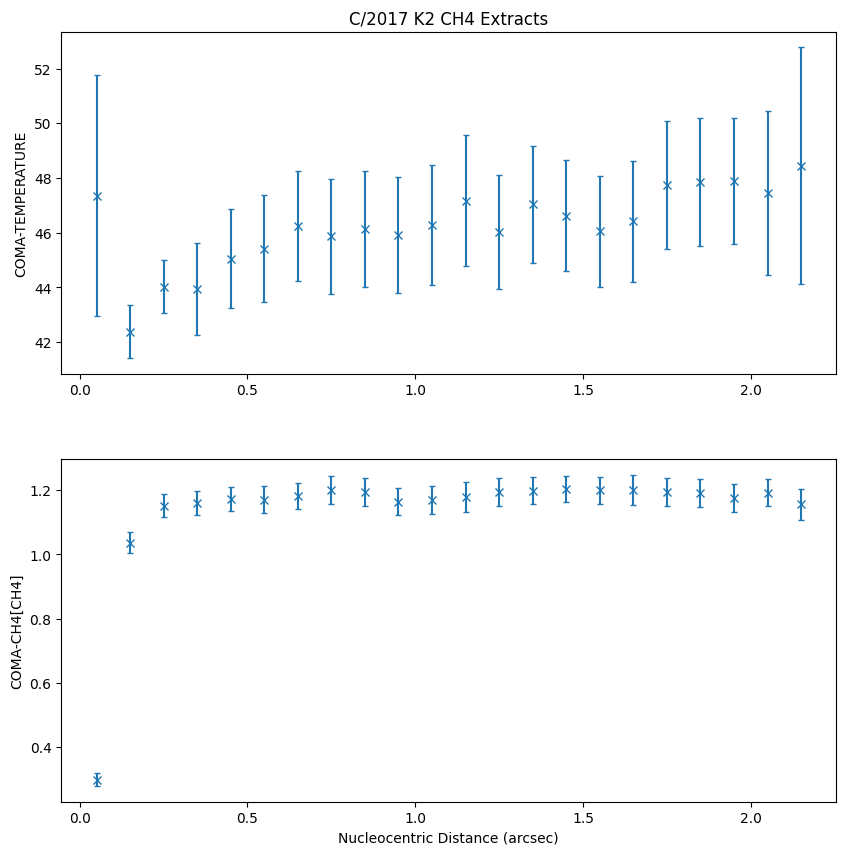

In [7]:
#Now save the results
fileStem = f'C2017K2-CH4-{annulusWidth.value:.1f}arcsec-annulus'
csvFile = fileStem+'-values.csv'
plotFile = fileStem+'-plots.pdf'
plotTitle='C/2017 K2 CH4 Extracts'
saveResults = modeling.savePSG()
if run_ret:
    saveResults.saveResults(csvFile=csvFile, retrieval_variables=retrieval_variables, retrieval_values=retrieval_values, retrieval_sigmas=retrieval_sigmas, extracts = [i.value for i in annuli.r_mids])
    saveResults.plotProfiles(csvFile=csvFile, plotFile=plotFile, plotTitle=plotTitle)